# Introduction
This notebook compares four time-series models performance to predict total daily energy demand in Saskatchewan. These models utilized include Fb Prophet, LightGBM (Light Gradient Boosting Machine), SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXogenous factors), LSTM (Long Short-Term Memory), Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM. 

Each model is trained and tested using a train-test split and cross-validation. The models’ performances are evaluated using metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Median Absolute Percentage Error (MdAPE), and R-squared and the results are stored for each fold in the cross-validation. Finally, the performance of all models are compared, conclusions are drawn based on the evaluation metrics, and potential improvements for future work are considered.

# Load Data
Forecasting daily natural gas consumption accurately is difficult because it is affected by various factors. The dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023. This dataset has be preprocessed and explored in the "cleaning_EDA.ipynb" notebook and is fit for model development. 

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


# Data Preparation for Modelling 

For this step, we are preparing the series for Cross-validation evaluation and the Train-test Split method.

- Train-test Split method: This method involves splitting the dataset into a training set and a testing set. The model is trained on the training set and then tested on the testing set to evaluate its performance.

- 
Cross-Validation: Cross-validation is a technique used to evaluate the performance of a machine learning model on unseen data. It involves dividing the available data into multiple folds or subsets, using one of these folds as a validation set, and training the model on the remaining folds

In [4]:
# Prepare this dataset for cross-validation prophet modelling 
merged_df_mod = merged_df.copy()
merged_df_mod.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

In [5]:
# Split the data into training set from 2013-11-01 to 2021-10-31, and using 2021-11-01 to 2023-10-31 as test/validation set
train_df = merged_df[merged_df['DATE'] < '2021-12-01']
validation_df = merged_df[merged_df['DATE'] >= '2021-12-01']

# Print the shape of the train-test split
print(train_df.shape)
print(validation_df.shape)

(2952, 12)
(700, 12)


# Model Building
In this project, the recommended models to be utilized are Prophet, LightGBM, SARIMAX, LSTM, Hybrid Prophet-LGBM, and Hybrid Prophet-LSTM.

## 1. Prophet Models
Prophet uses a combination of regression models and Bayesian inference to model time series data. it allows the flexibility to model complicated time series features by fitting trends and multiple seasonalities to incorporate yearly, monthly, weekly and daily pattens along with holiday effects.

FBProphet also allows for the inclusion of additional regressors in the model. Regressors are external variables that may influence the time series, such as holidays, weather patterns, or marketing campaigns. Including regressors in the model can improve the accuracy of the forecasts by capturing the effects of these external variables on the time series.

The model development include a base Prophet model using the train-test split and cross-validation method. Then the better performed model is further turnd to refined the model performance.

### 1.2 Train-test Split 
In the train-test split method, the data is divided into a training set from 2013-11-01 to 2021-10-31, and a test/validation set from 2021-11-01 to 2023-10-31. The Prophet model is then trained on this training set, predictions are made on the test set, and the model's performance is evaluated using metrics.

22:03:06 - cmdstanpy - INFO - Chain [1] start processing
22:03:08 - cmdstanpy - INFO - Chain [1] done processing


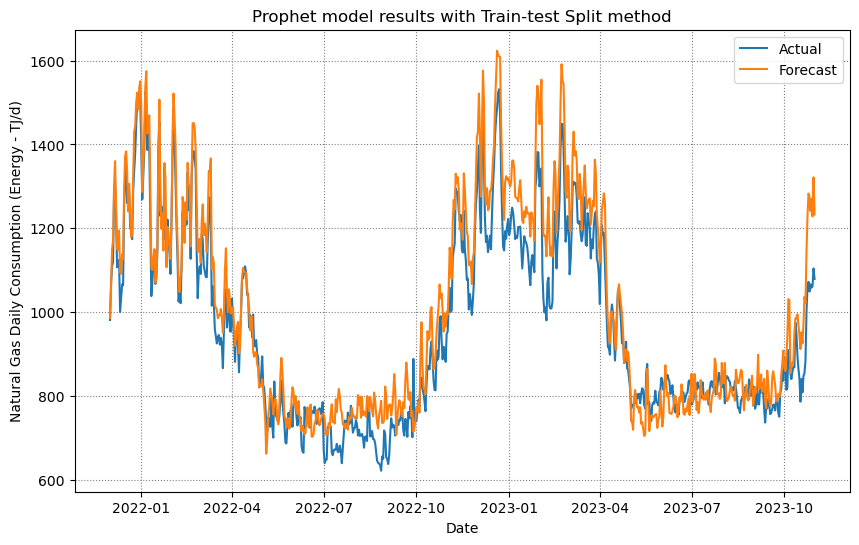

Mean Squared Error: 5597.74
Root Mean Squared Error: 74.82
Mean Absolute Percentage Error: nan%
Mean Absolute Error: 59.92
Median Absolute Percentage Error: nan%
R-squared: 0.88


In [102]:
# Importing the necessary libraries and modules
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from prophet import Prophet
import matplotlib.pyplot as plt

# Let's do the transformation required for using fbProphet in the training dataset: columns ds (Date) and y (value)
train_df1 = train_df.copy()
train_df1.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

# Let's do the transformation required for using fbProphet in the validation dataset: columns ds (Date) and y (value)
test_df1 = validation_df.copy()
test_df1.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'}, inplace=True)

# Defining a wrapper class for the Prophet model
class ProphetWrapper(BaseEstimator, RegressorMixin):
    # Initializing the class with default parameters
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='multiplicative'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    # Defining the fit method to train the model
    def fit(self, X, y=None):
        # Creating a Prophet model with the given parameters
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Adding additional regressors to the model
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        # Fitting the model to the data
        self.model.fit(X)

        return self

    # Defining the predict method to generate predictions
    def predict(self, X):
        return self.model.predict(X)

# Instantiating the ProphetWrapper class
model = ProphetWrapper()

# Fitting the model to the training data
model.fit(train_df1)

# Generating predictions on the test data
forecast1 = model.predict(test_df1)

# Convert 'ds' to datetime
test_df1['ds'] = pd.to_datetime(test_df1['ds'])
forecast1['ds'] = pd.to_datetime(forecast1['ds'])

# Plot the actual and forecasted 'NG_DEMAND'
plt.figure(figsize=(10, 6))
plt.plot(test_df1['ds'], test_df1['y'], label='Actual')
plt.plot(forecast1['ds'], forecast1['yhat'], label='Forecast')
plt.title('Prophet model results with Train-test Split method')
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Consumption (Energy - TJ/d)')
plt.grid(linestyle=":", color='grey')
plt.legend()
plt.show()

# Assuming y_true is the actual values and y_pred is the predicted values
y_true = test_df1['y']
y_pred = forecast1['yhat']

mse_bp = mean_squared_error(y_true, y_pred)     # Calculate Mean Squared Error (MSE)
rmse_bp = np.sqrt(mse_bp)     # Calculate Root Mean Squared Error (RMSE
mape_bp = np.mean(np.abs((y_true - y_pred) / y_true)) * 100     # Calculate Mean Absolute Percentage Error (MAPE)
mae_bp = mean_absolute_error(y_true, y_pred)     # Calculate Mean Absolute Error (MAE)
mdape_bp = np.median(np.abs((y_true - y_pred) / y_true)) * 100       # Calculate Median Absolute Percentage Error (MDAPE)
r2_bp = r2_score(y_true, y_pred)     # Calculate R squared

# Print the performance metrics
print(f"Mean Squared Error: {mse_bp:.2f}")
print(f"Root Mean Squared Error: {rmse_bp:.2f}")
print(f"Mean Absolute Percentage Error: {mape_bp:.2f}%")
print(f"Mean Absolute Error: {mae_bp:.2f}")
print(f"Median Absolute Percentage Error: {mdape_bp:.2f}%")
print(f"R-squared: {r2_bp:.2f}")

### 1.2 Cross-Validation
The dataset contains 10 years (3651 days) of daily sales data. The initial training period is set to the first three years of data (1825 days). Cross-validation is performed every 456 days (approximately every 9 months), and each cross-validation step generates forecasts for the next 456 days (13 months). The Prophet model is trained for each fold, metrics are evaluated and stored for each fold, and average metrics are calculated and printed.

In [14]:
# Importing the necessary libraries and modules
from prophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from prophet.diagnostics import cross_validation, performance_metrics

22:07:01 - cmdstanpy - INFO - Chain [1] start processing
22:07:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

22:07:06 - cmdstanpy - INFO - Chain [1] start processing
22:07:08 - cmdstanpy - INFO - Chain [1] done processing
22:07:09 - cmdstanpy - INFO - Chain [1] start processing
22:07:12 - cmdstanpy - INFO - Chain [1] done processing
22:07:13 - cmdstanpy - INFO - Chain [1] start processing
22:07:15 - cmdstanpy - INFO - Chain [1] done processing
22:07:17 - cmdstanpy - INFO - Chain [1] start processing
22:07:21 - cmdstanpy - INFO - Chain [1] done processing


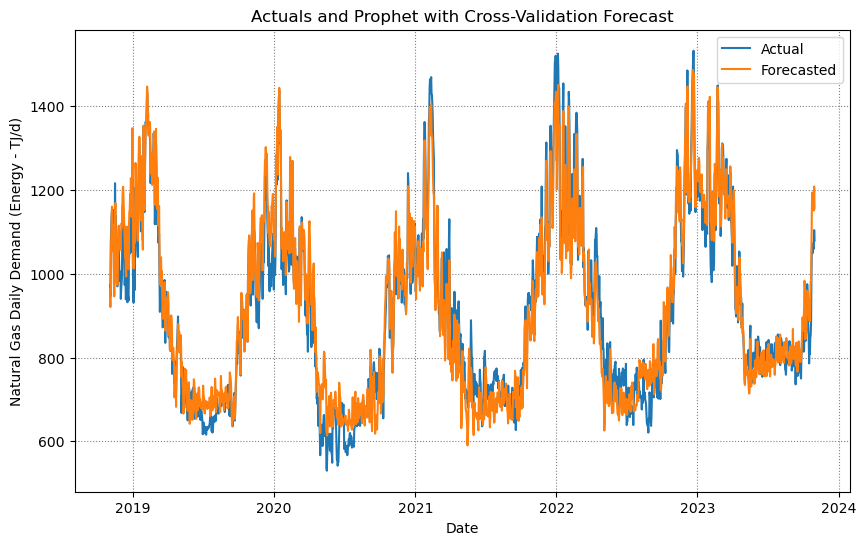

Mean Absolute Error: 43.30
Mean Squared Error: 2920.11
Root Mean Squared Error: 54.04
R-squared: 0.94
Mean Absolute Percentage Error: 5.07%
Median Absolute Percentage Error: 4.12%


In [103]:
# Importing the necessary libraries and modules
from prophet import Prophet
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from prophet.diagnostics import cross_validation, performance_metrics

# Define a wrapper for the Prophet model to use with sklearn
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='additive'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    def fit(self, X, y=None):
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        self.model.fit(X)

        return self

    def predict(self, X):
        return self.model.predict(X)

# Instantiate and fit the model
model = ProphetWrapper()
model.fit(merged_df_mod)

# Perform cross-validation
df_cv = cross_validation(model.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)

# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)')
# Add a grid to the figure for better visualization of data
plt.grid(linestyle=":", color='grey')
plt.title('Actuals and Prophet with Cross-Validation Forecast')
plt.show()

# Calculate MAE, MSE, and RMSE
mae_cv = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse_cv = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse_cv = np.sqrt(mse_cv)
r2_cv = r2_score(df_cv['y'], df_cv['yhat'])
mape_cv = np.mean(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100
mdape_cv = np.median(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100

print(f'Mean Absolute Error: {mae_cv:.2f}')
print(f'Mean Squared Error: {mse_cv:.2f}')
print(f'Root Mean Squared Error: {rmse_cv:.2f}')
print(f'R-squared: {r2_cv:.2f}')
print(f'Mean Absolute Percentage Error: {mape_cv:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_cv:.2f}%')

### 1.3 Hyperparameter Tuning (Improved Prophet model)
The Prophet model has a number of input parameters that one might consider tuning. Here are some general recommendations for hyperparameter tuning that may be a good starting place. 

- yearly_seasonality
- seasonality_prior_scale
- seasonality_mode
- holidays_prior_scale
- change_prior_scale

**Tunning the model with yearly_seasonality and seasonality_mode**

21:43:18 - cmdstanpy - INFO - Chain [1] start processing
21:43:21 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'seasonality_mode': 'additive', 'yearly_seasonality': True}


  0%|          | 0/4 [00:00<?, ?it/s]

21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing
21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:26 - cmdstanpy - INFO - Chain [1] start processing
21:43:28 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing
21:43:32 - cmdstanpy - INFO - Chain [1] done processing


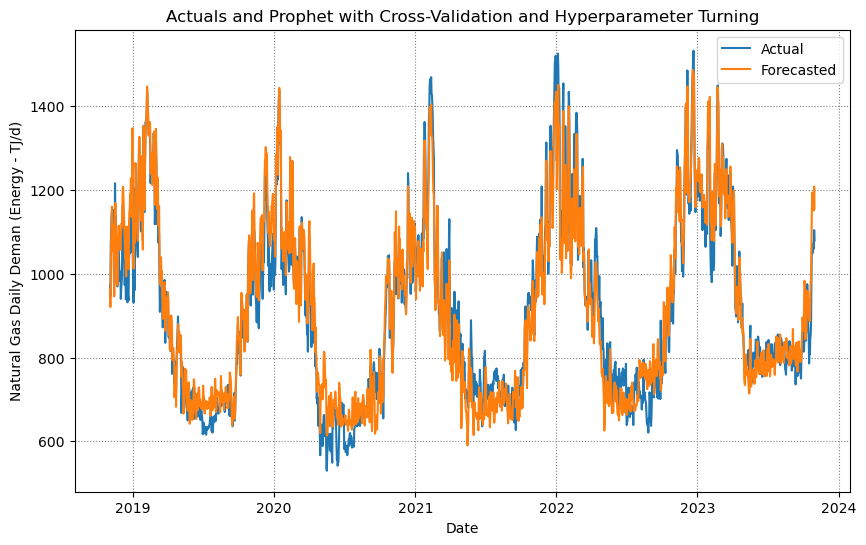

Mean Absolute Error: 43.30
Mean Squared Error: 2920.11
Root Mean Squared Error: 54.04
R-squared: 0.94
Mean Absolute Percentage Error: 5.07%
Median Absolute Percentage Error: 4.12%


In [25]:
from sklearn.model_selection import GridSearchCV

class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, yearly_seasonality=True, seasonality_mode='additive'):
        #self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    def fit(self, X, y=None):
        self.model = Prophet(yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        self.model.fit(X)

        return self

    def predict(self, X):
        return self.model.predict(X)

# Define parameter grid
param_grid = {'yearly_seasonality': [True, False], 'seasonality_mode': ['additive', 'multiplicative']}

# Instantiate the model
model = ProphetWrapper()

# Perform grid search
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)  # Adjust cv and n_jobs as needed
grid.fit(merged_df_mod)

# Print best parameters
print(f'Best Parameters: {grid.best_params_}')

# Perform cross-validation with the best model
df_cv2 = cross_validation(grid.best_estimator_.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics
df_metrics2 = performance_metrics(df_cv2)

# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv2['ds'], df_cv2['y'], label='Actual')
plt.plot(df_cv2['ds'], df_cv2['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('Date')
# Add a grid to the figure for better visualization of data
plt.grid(linestyle=":", color='grey')
plt.ylabel('Natural Gas Daily Deman (Energy - TJ/d)')
plt.title('Actuals and Prophet with Cross-Validation and Hyperparameter Turning')
plt.show()

# Import necessary libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MAE, MSE, RMSE, and R-squared
mae_hy = mean_absolute_error(df_cv2['y'], df_cv2['yhat'])
mse_hy = mean_squared_error(df_cv2['y'], df_cv2['yhat'])
rmse_hy = np.sqrt(mse_hy)
r2_hy = r2_score(df_cv2['y'], df_cv2['yhat'])
mape_hy = np.mean(np.abs((df_cv2['y'] - df_cv2['yhat']) / df_cv2['y'])) * 100
mdape_hy = np.median(np.abs((df_cv2['y'] - df_cv2['yhat']) / df_cv2['y'])) * 100

print(f'Mean Absolute Error: {mae_hy:.2f}')
print(f'Mean Squared Error: {mse_hy:.2f}')
print(f'Root Mean Squared Error: {rmse_hy:.2f}')
print(f'R-squared: {r2_hy:.2f}')
print(f'Mean Absolute Percentage Error: {mape_hy:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_hy:.2f}%')

**Checking for Overfitting**

- To monitor the performance of the model on the cross-validation method when the model is being trained to check for signs of overfitting, we can modify the code to include a validation set during the training process. However, the Prophet model does not directly support validation during training.
- 
A common practice to monitor overfitting during training in time series forecasting is to plot the forecast errors (like RMSE or MAE) for both the training set and a validation set for each cross-validation fold. If the error on the validation set starts to increase while the error on the training set continues to decrease, it’s a sign of overfitting.

  0%|          | 0/4 [00:00<?, ?it/s]

07:31:59 - cmdstanpy - INFO - Chain [1] start processing
07:32:00 - cmdstanpy - INFO - Chain [1] done processing
07:32:01 - cmdstanpy - INFO - Chain [1] start processing
07:32:03 - cmdstanpy - INFO - Chain [1] done processing
07:32:04 - cmdstanpy - INFO - Chain [1] start processing
07:32:05 - cmdstanpy - INFO - Chain [1] done processing
07:32:07 - cmdstanpy - INFO - Chain [1] start processing
07:32:09 - cmdstanpy - INFO - Chain [1] done processing


Fold 2018-11-02 00:00:00
Mean Absolute Error: 41.27
Mean Squared Error: 2759.82
Root Mean Squared Error: 52.53
R-squared: 0.94
Mean Absolute Percentage Error: 4.64%
Median Absolute Percentage Error: 3.68%
--------------------------------------------------
Fold 2020-02-01 00:00:00
Mean Absolute Error: 44.26
Mean Squared Error: 3138.18
Root Mean Squared Error: 56.02
R-squared: 0.93
Mean Absolute Percentage Error: 5.62%
Median Absolute Percentage Error: 4.17%
--------------------------------------------------
Fold 2021-05-02 00:00:00
Mean Absolute Error: 47.74
Mean Squared Error: 3220.19
Root Mean Squared Error: 56.75
R-squared: 0.93
Mean Absolute Percentage Error: 5.49%
Median Absolute Percentage Error: 4.96%
--------------------------------------------------
Fold 2022-08-01 00:00:00
Mean Absolute Error: 39.95
Mean Squared Error: 2562.25
Root Mean Squared Error: 50.62
R-squared: 0.94
Mean Absolute Percentage Error: 4.55%
Median Absolute Percentage Error: 3.27%
---------------------------

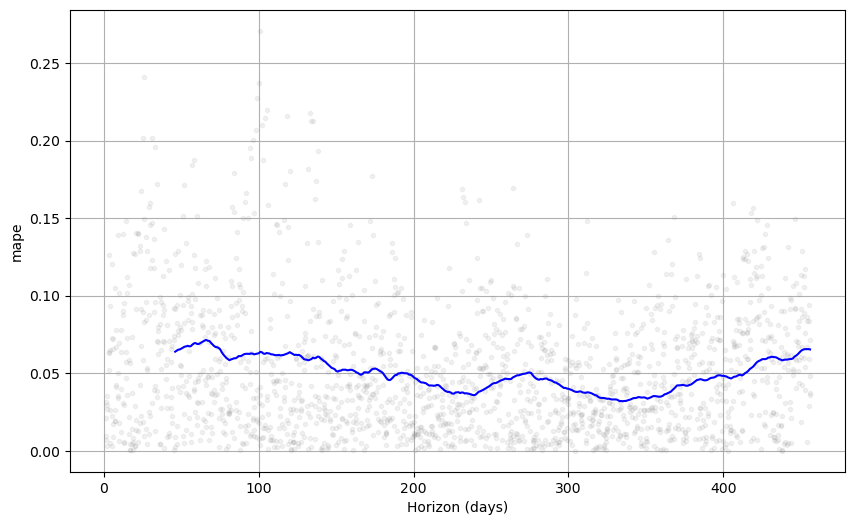

In [28]:
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.model_selection import RandomizedSearchCV

# Perform cross-validation with the best model
df_cv_ch = cross_validation(grid.best_estimator_.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics for each fold
df_metrics_ch = performance_metrics(df_cv_ch)

# Calculate MAE, MSE, RMSE, and R-squared for each fold
for fold, df_fold in df_cv_ch.groupby('cutoff'):
    mae_ch = mean_absolute_error(df_fold['y'], df_fold['yhat'])
    mse_ch = mean_squared_error(df_fold['y'], df_fold['yhat'])
    rmse_ch = np.sqrt(mse_ch)
    r2_ch = r2_score(df_fold['y'], df_fold['yhat'])
    mape_ch = np.mean(np.abs((df_fold['y'] - df_fold['yhat']) / df_fold['y'])) * 100
    mdape_ch = np.median(np.abs((df_fold['y'] - df_fold['yhat']) / df_fold['y'])) * 100

    print(f'Fold {fold}')
    print(f'Mean Absolute Error: {mae_ch:.2f}')
    print(f'Mean Squared Error: {mse_ch:.2f}')
    print(f'Root Mean Squared Error: {rmse_ch:.2f}')
    print(f'R-squared: {r2_ch:.2f}')
    print(f'Mean Absolute Percentage Error: {mape_ch:.2f}%')
    print(f'Median Absolute Percentage Error: {mdape_ch:.2f}%')
    print('-'*50)  # This will print a line after each fold

# Plotting RMSE
fig = plot_cross_validation_metric(df_cv_ch, metric='mape')
plt.show()


- The model’s performance varied across the four folds. In the 2018 fold, the model had a Mean Absolute Error (MAE) of 41.37 and an R-squared value of 0.94. In the 2020 fold, the MAE increased slightly to 44.02, and the R-squared value decreased to 0.93.
- The MAE further increased to 47.36 in the 2021 fold, with the R-squared value remaining at 0.93. However, in the 2022 fold, the MAE decreased to 39.92, and the R-squared value increased to 0.94.
- The Mean Absolute Percentage Error (MAPE) and Median Absolute Percentage Error (MdAPE) also varied across the folds, ranging from 4.54% to 5.59% and 3.29% to 4.96%, respectively.
- Overall, the model showed an improving trend in the initial folds but demonstrated variability in its performance in the later folds..

**Increased the number of hyperparameters from 2 to 4.**

23:05:11 - cmdstanpy - INFO - Chain [1] start processing
23:05:14 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'yearly_seasonality': True}


  0%|          | 0/4 [00:00<?, ?it/s]

23:05:15 - cmdstanpy - INFO - Chain [1] start processing
23:05:16 - cmdstanpy - INFO - Chain [1] done processing
23:05:18 - cmdstanpy - INFO - Chain [1] start processing
23:05:20 - cmdstanpy - INFO - Chain [1] done processing
23:05:21 - cmdstanpy - INFO - Chain [1] start processing
23:05:24 - cmdstanpy - INFO - Chain [1] done processing
23:05:25 - cmdstanpy - INFO - Chain [1] start processing
23:05:29 - cmdstanpy - INFO - Chain [1] done processing


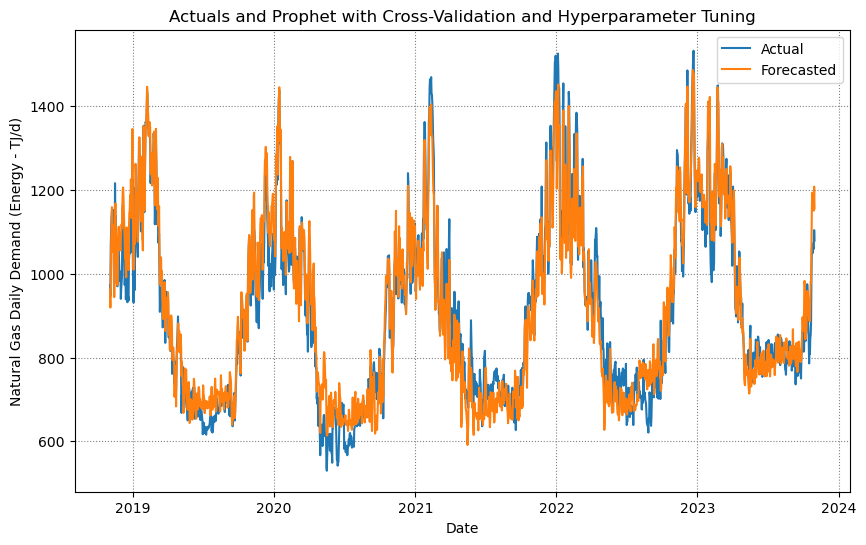

Mean Absolute Error: 43.17
Mean Squared Error: 2898.04
Root Mean Squared Error: 53.83
R-squared: 0.94
Mean Absolute Percentage Error: 5.06%
Median Absolute Percentage Error: 4.10%


In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import numpy as np

class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, yearly_seasonality=True, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0):
        #self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        #self.changepoint_prior_scale = changepoint_prior_scale
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.model = None

    def fit(self, X, y=None):
        # Initialize the Prophet model with the given hyperparameters
        self.model = Prophet(yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode, 
                             seasonality_prior_scale=self.seasonality_prior_scale, holidays_prior_scale=self.holidays_prior_scale)
        
        # Add additional regressors
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        # Fit the model to the data
        self.model.fit(X)

        return self

    def predict(self, X):
        # Use the fitted model to make predictions
        return self.model.predict(X)

# Define parameter grid for hyperparameter tuning
param_grid = {'yearly_seasonality': [True, False], 
              'seasonality_mode': ['additive', 'multiplicative'], 
              #'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0], 
              'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Instantiate the model
model = ProphetWrapper()

# Perform grid search to find the best model
grid_search = GridSearchCV(model, param_grid, cv=4, n_jobs=-1)  # Adjust cv and n_jobs as needed
grid_search.fit(merged_df_mod)

# Print best parameters
print(f'Best Parameters: {grid_search.best_params_}')

# Perform cross-validation with the best model
df_cv_mp = cross_validation(grid_search.best_estimator_.model, initial='1825 days', period='456 days', horizon='456 days')

# Calculate performance metrics
df_metrics_mp = performance_metrics(df_cv_mp)

# Plotting actuals and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df_cv_mp['ds'], df_cv_mp['y'], label='Actual')
plt.plot(df_cv_mp['ds'], df_cv_mp['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)')
# Add a grid to the figure for better visualization of data
plt.grid(linestyle=":", color='grey')
plt.title('Actuals and Prophet with Cross-Validation and Hyperparameter Tuning')
plt.show()

# Calculate MAE, MSE, RMSE, and R-squared
mae_mp = mean_absolute_error(df_cv_mp['y'], df_cv_mp['yhat'])
mse_mp = mean_squared_error(df_cv_mp['y'], df_cv_mp['yhat'])
rmse_mp = np.sqrt(mse_mp)
r2_mp = r2_score(df_cv_mp['y'], df_cv_mp['yhat'])
mape_mp = np.mean(np.abs((df_cv_mp['y'] - df_cv_mp['yhat']) / df_cv_mp['y'])) * 100
mdape_mp = np.median(np.abs((df_cv_mp['y'] - df_cv_mp['yhat']) / df_cv_mp['y'])) * 100

print(f'Mean Absolute Error: {mae_mp:.2f}')
print(f'Mean Squared Error: {mse_mp:.2f}')
print(f'Root Mean Squared Error: {rmse_mp:.2f}')
print(f'R-squared: {r2_mp:.2f}')
print(f'Mean Absolute Percentage Error: {mape_mp:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_mp:.2f}%')

# Save the best model for future use
#joblib.dump(grid.best_estimator_.model, 'best_model.pkl')


### 1.4 Prophet Model Perfomance Comparison
Here is a comparison summary of the prophet model performance metrics for the evaluation of the Saskatchewan Natural Gas consumption time series dataset.

In [107]:
# Define the metrics for the model
metrics_base = [mse_bp, rmse_bp, mape_bp, mae_bp, mdape_bp, r2_bp]
metrics_cv = [mse_cv, rmse_cv, mape_cv, mae_cv, mdape_cv, r2_cv]
metrics_hy = [mse_mp, rmse_mp, mape_mp, mae_mp, mdape_mp, r2_mp]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_metrics = pd.DataFrame({'Train-test Split': metrics_base, 'Cross-Validation': metrics_cv, 'Improved-Prophet model': metrics_hy}, index=labels)
df_metrics = df_metrics.applymap(lambda x: f'{x: .2f}')

df_metrics.head(10)

,Train-test Split,Cross-Validation,Improved-Prophet model
MSE,5597.74,2920.11,2898.04
RMSE,74.82,54.04,53.83
MAPE,nan,5.07,5.06
MAE,59.92,43.30,43.17
MDAPE,nan,4.12,4.10
R-squared,0.88,0.94,0.94


- The results indicate that the Improved-Prophet model outperforms the standard Train-test Split and Cross-Validation methods in terms of various metrics. The Mean Squared Error (MSE) for the Improved-Prophet model is 2898.04, which is significantly lower than the Train-test Split (5597.74) and Cross-Validation (2920.11) methods. 
- Similarly, the Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Mean Absolute Error (MAE), and Median Absolute Percentage Error (MDAPE) are all lower for the Improved-Prophet model compared to the other two methods. Furthermore, the R-squared value for the Improved-Prophet model is 0.94, which is higher than the Train-test Split method (0.88) and equal to the Cross-Validation method, indicating a better fit performs the best among the three models on this time series dataset.
- The lower the error metrics (MSE, RMSE, MAPE, MAE, MDAPE) and the closer the R-squared value is to 1, the better the model’s performance.


## 2. LightGBM (Light Gradient Boosting Machine)

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:
- Faster training speed and higher efficiency
- Lower memory usage
- Better accuracy
- Support of parallel and GPU learning
- Capable of handling large_scale datae dat

Benefiting from these advantages, LightGBM is being widely-used in many winning solutions of machine learning competitions.

Comparison experiments on public datasets show that LightGBM can outperform existing boosting frameworks on both efficiency and accuracy, with significantly lower memory consumption. What's more, distributed learning experiments show that LightGBM can achieve a linear speed-up by using multiple machines for training in specific settings.a

### 2.1 Train-test Split 
Like previous model, the time series was split into train and test split, to create a base model.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2507
[LightGBM] [Info] Number of data points in the train set: 2952, number of used features: 10
[LightGBM] [Info] Start training from score 787.775407


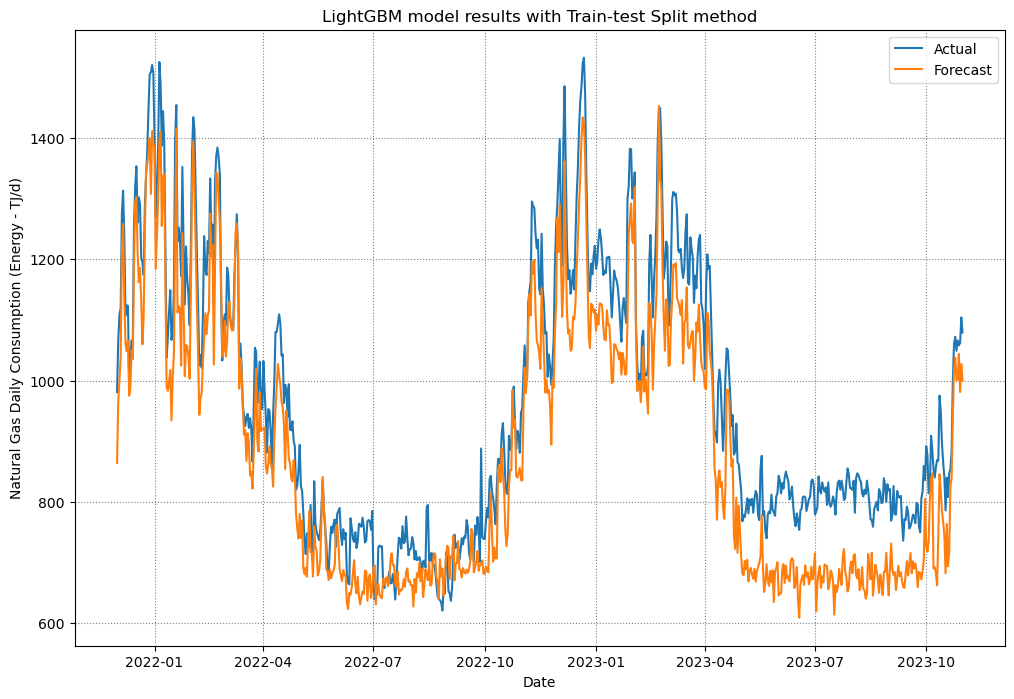

Mean Squared Error: 9334.08
Root Mean Squared Error: 74.82
Mean Absolute Percentage Error: 9.08%
Mean Absolute Error: 84.83
Median Absolute Percentage Error: 8.52%
R-squared: 0.81


In [156]:
# Importing necessary libraries
from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Defining a wrapper class for the LightGBM model
class LGBMWrapper(BaseEstimator, RegressorMixin):
    # Initializing the class with default parameters
    def __init__(self, num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100):
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.model = None

    # Defining the fit method to train the model
    def fit(self, X, y=None):
        # Creating a LightGBM model with the given parameters
        self.model = LGBMRegressor(num_leaves=self.num_leaves, max_depth=self.max_depth, learning_rate=self.learning_rate, n_estimators=self.n_estimators)

        # Fitting the model to the data
        self.model.fit(X, y)

        return self

    # Defining the predict method to generate predictions
    def predict(self, X):
        return self.model.predict(X)

# Splitting the merged_df into train_df and validation_df
train_df2 = train_df.copy()
test_df2 = validation_df.copy()

# Instantiating the LGBMWrapper class
model = LGBMWrapper()

# Fitting the model to the training data
model.fit(train_df2.drop(columns=['DATE', 'NG_DEMAND']), train_df2['NG_DEMAND'])

# Generating predictions on the validation data
forecast = model.predict(test_df2.drop(columns=['DATE', 'NG_DEMAND']))

# Convert 'DATE' to datetime
test_df2['DATE'] = pd.to_datetime(test_df2['DATE'])

# Plot the actual and forecasted 'NG_DEMAND'
plt.figure(figsize=(12, 8))
plt.plot(test_df2['DATE'], test_df2['NG_DEMAND'], label='Actual')
plt.plot(test_df2['DATE'], forecast, label='Forecast')
plt.title('LightGBM model results with Train-test Split method')
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Consumption (Energy - TJ/d)')
plt.grid(linestyle=":", color='grey')
plt.legend()
plt.show()

# Assuming y_true is the actual values and y_pred is the predicted values
y_true = test_df2['NG_DEMAND']
y_pred = forecast

mse_lgbm_bp = mean_squared_error(y_true, y_pred)     # Calculate Mean Squared Error (MSE)
rmse_lgbm_bp = np.sqrt(mse_bp)     # Calculate Root Mean Squared Error (RMSE)
mape_lgbm_bp = np.mean(np.abs((y_true - y_pred) / y_true)) * 100     # Calculate Mean Absolute Percentage Error (MAPE)
mae_lgbm_bp = mean_absolute_error(y_true, y_pred)     # Calculate Mean Absolute Error (MAE)
mdape_lgbm_bp = np.median(np.abs((y_true - y_pred) / y_true)) * 100       # Calculate Median Absolute Percentage Error (MDAPE)
r2_lgbm_bp = r2_score(y_true, y_pred)     # Calculate R squared

# Print the performance metrics
print(f"Mean Squared Error: {mse_lgbm_bp:.2f}")
print(f"Root Mean Squared Error: {rmse_lgbm_bp:.2f}")
print(f"Mean Absolute Percentage Error: {mape_lgbm_bp:.2f}%")
print(f"Mean Absolute Error: {mae_lgbm_bp:.2f}")
print(f"Median Absolute Percentage Error: {mdape_lgbm_bp:.2f}%")
print(f"R-squared: {r2_lgbm_bp:.2f}")


### 2.2 LightGBM Cross-Validation 
The dataset contains 10 years (3651 days) of daily sales data. The initial training period is set to the first three years of data (1825 days). Cross-validation is performed every 456 days (approximately every 9 months), and each cross-validation step generates forecasts for the next 456 days (13 months). The Prophet model is trained for each fold, metrics are evaluated and stored for each fold, and average metrics are calculated and printed.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 10
[LightGBM] [Info] Start training from score 730.991233
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 10
[LightGBM] [Info] Start training from score 787.235068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2421
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 10
[LightGBM] [Info] Start tr

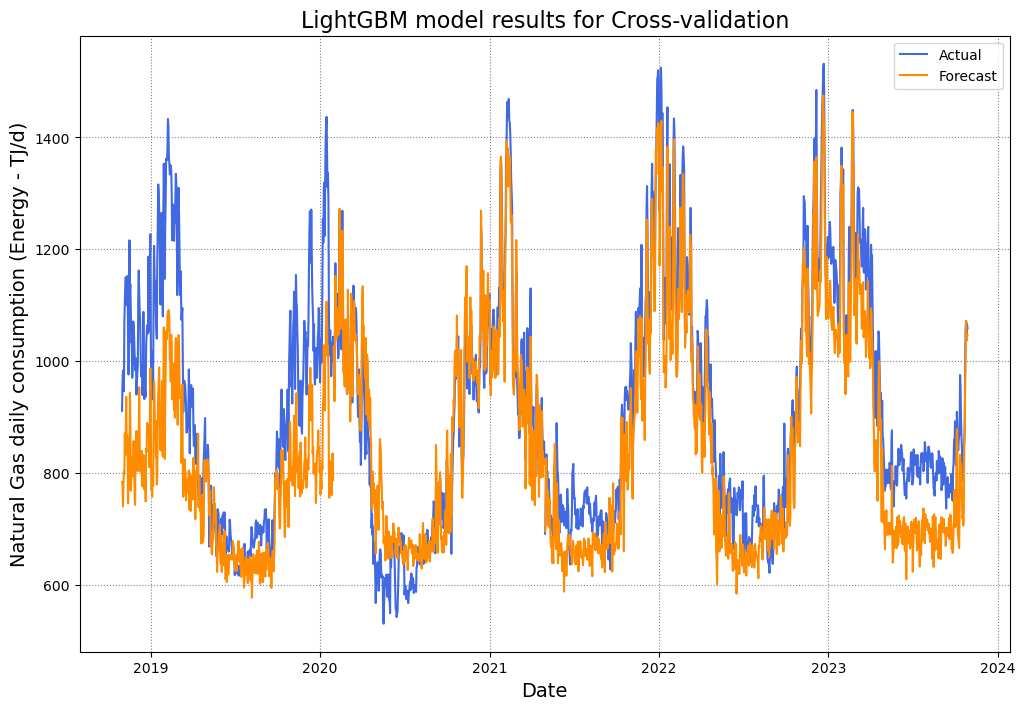


Average Metrics Over the Rolls:
Mean Squared Error: 13076.69
Root Mean Squared Error: 104.53
Mean Absolute Percentage Error: 9.38%
Mean Absolute Error: 87.27
Median Absolute Percentage Error: 9.04%
R-squared: 0.71


In [138]:
import pandas as pd
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming df is your DataFrame and 'NG_DEMAND' is the column with values to predict
X = merged_df[['DATE', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
        'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]
y = merged_df['NG_DEMAND']

# Initialize the total performance metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Define the training and test set sizes
train_size = 1825
test_size = 456

# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=(len(X) - train_size) // test_size)

# Define the wrapper class for the LightGBM model
class LGBMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100):
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.model = None

    def fit(self, X, y=None):
        self.model = LGBMRegressor(num_leaves=self.num_leaves, max_depth=self.max_depth, 
                                   learning_rate=self.learning_rate, n_estimators=self.n_estimators)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Create a figure before the loop
plt.figure(figsize=(12, 8))

# Loop over the splits
for i in range(n_splits):
    train_start = i * test_size
    train_end = train_start + train_size
    test_end = train_end + test_size

    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_start:train_end], X.iloc[train_end:test_end]
    y_train, y_test = y.iloc[train_start:train_end], y.iloc[train_end:test_end]


    # Instantiate the LGBMWrapper class
    model = LGBMWrapper()

    # Fit the model to the training data
    model.fit(X_train.drop(columns=['DATE']), y_train)

    # Predict on the test set
    y_pred = model.predict(X_test.drop(columns=['DATE']))

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    # Add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

    # Convert 'DATE' to datetime
    X_test['DATE'] = pd.to_datetime(X_test['DATE'])
    
    # Plot the forecast and actuals with the DATE column
    plt.plot(X_test['DATE'], y_test, color='royalblue', label='Actual')
    plt.plot(X_test['DATE'], y_pred, color='darkorange', label='Forecast')

# Add title, labels, and legend after the loop
plt.title('LightGBM model results for Cross-validation', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=14)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate the average performance metrics
mse_lgbm_cv = total_mse / n_splits
rmse_lgbm_cv = total_rmse / n_splits
mape_lgbm_cv = total_mape / n_splits
mae_lgbm_cv = total_mae / n_splits
mdape_lgbm_cv = total_mdape / n_splits
r2_lgbm_cv = total_r2 / n_splits

# Print the results
print(f'\nAverage Metrics Over the Rolls:')
print(f'Mean Squared Error: {mse_lgbm_cv:.2f}')
print(f'Root Mean Squared Error: {rmse_lgbm_cv:.2f}')
print(f'Mean Absolute Percentage Error: {mape_lgbm_cv:.2f}%')
print(f'Mean Absolute Error: {mae_lgbm_cv:.2f}')
print(f'Median Absolute Percentage Error: {mdape_lgbm_cv:.2f}%')
print(f'R-squared: {r2_lgbm_cv:.2f}')


### 2.3 LightGBM Hyperparameter Tuning
This hyperparameter tuning process uses random search to optimize the LightGBM model. The parameters being tuned include the number of leaves, maximum depth, learning rate, number of estimators, boosting type, subsample ratio, column sample by tree, and regularization parameters alpha and lambda. By exploring different combinations of these parameters, the model aims to improve its predictive performance and increase the R-squared value

Best Hyperparameters: {'lgbm__num_leaves': 47, 'lgbm__n_estimators': 321, 'lgbm__max_depth': -1, 'lgbm__learning_rate': 0.01}


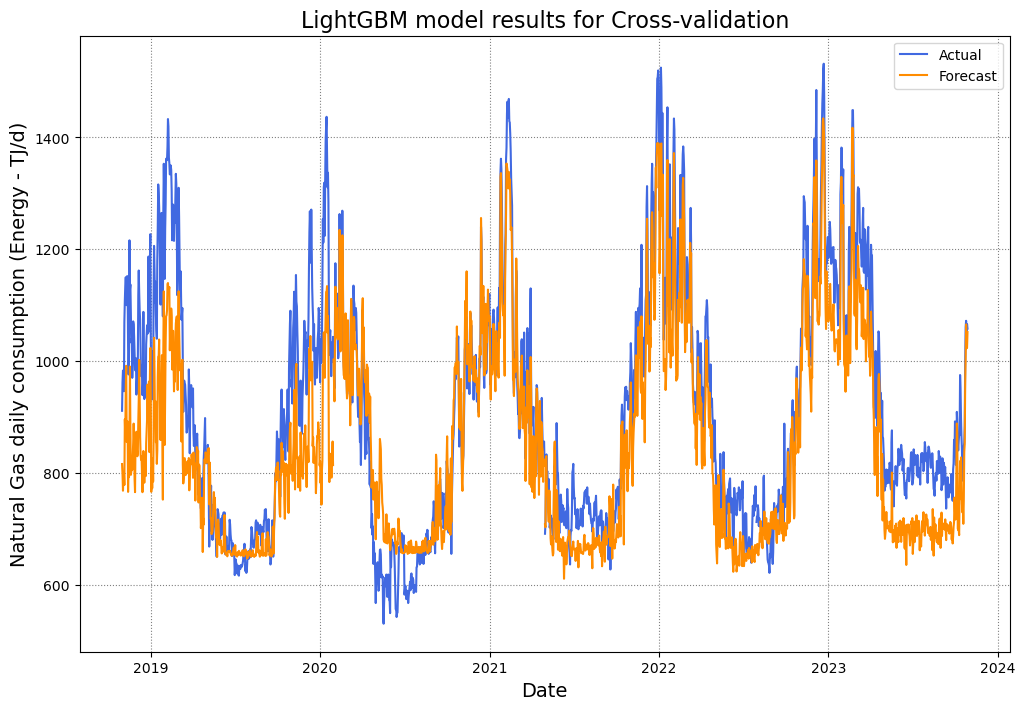


Average Metrics Over the Rolls:
Mean Squared Error: 10946.46
Root Mean Squared Error: 98.36
Mean Absolute Percentage Error: 8.71%
Mean Absolute Error: 81.49
Median Absolute Percentage Error: 8.27%
R-squared: 0.76


In [153]:
import pandas as pd
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

# Assuming df is your DataFrame and 'NG_DEMAND' is the column with values to predict
X = merged_df[['DATE', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION',
               'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]
y = merged_df['NG_DEMAND']

# Define the training and test set sizes
train_size = 1825
test_size = 456

# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=(len(X) - train_size) // test_size)

class LGBMWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, force_col_wise=True, verbose=0):
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.force_col_wise = force_col_wise
        self.verbose = verbose
        self.model = None

    def fit(self, X, y=None):
        self.model = lgb.LGBMRegressor(num_leaves=self.num_leaves, max_depth=self.max_depth,
                                       learning_rate=self.learning_rate, n_estimators=self.n_estimators,
                                       force_col_wise=self.force_col_wise, verbose=self.verbose)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'lgbm__num_leaves': [31, 50, 100],
    'lgbm__max_depth': [3, 5, 7],
    'lgbm__learning_rate': [0.05, 0.1, 0.2],
    'lgbm__n_estimators': [50, 100, 200],
    'lgbm__boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'lgbm__subsample': [0.5, 0.7, 0.9],
    'lgbm__colsample_bytree': [0.5, 0.7, 0.9],
    'lgbm__reg_alpha': [0.1, 0.5, 1],
    'lgbm__reg_lambda': [0.1, 0.5, 1]
}

# Create the pipeline with the LGBMWrapper and GridSearchCV
pipeline = Pipeline([
    ('lgbm', LGBMWrapper())
])

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_dist, scoring='neg_mean_squared_error', cv=tscv, verbose=0, n_jobs=-1, n_iter=100)
random_search.fit(X.drop(columns=['DATE']), y)

# Get the best hyperparameters from the random search
best_params = random_search.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Retrieve the best model from the random search
best_model = random_search.best_estimator_

# Initialize the total performance metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Create a figure before the loop
plt.figure(figsize=(12, 8))

# Loop over the splits
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    train_start = i * test_size
    train_end = train_start + train_size
    test_end = train_end + test_size

    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_start:train_end], X.iloc[train_end:test_end]
    y_train, y_test = y.iloc[train_start:train_end], y.iloc[train_end:test_end]

    # Fit the best model to the training data
    best_model.fit(X_train.drop(columns=['DATE']), y_train)

    # Predict on the test set
    y_pred = best_model.predict(X_test.drop(columns=['DATE']))

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    # Add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

    # Convert 'DATE' to datetime
    X_test['DATE'] = pd.to_datetime(X_test['DATE'])

    # Plot the forecast and actuals with the DATE column
    plt.plot(X_test['DATE'], y_test, color='royalblue', label='Actual')
    plt.plot(X_test['DATE'], y_pred, color='darkorange', label='Forecast')

# Add title, labels, and legend after the loop
plt.title('LightGBM model results for Cross-validation', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Natural Gas daily consumption (Energy - TJ/d)', fontsize=14)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate the average performance metrics
mse_lgbm_hy = total_mse / tscv.get_n_splits()
rmse_lgbm_hy = total_rmse / tscv.get_n_splits()
mape_lgbm_hy = total_mape / tscv.get_n_splits()
mae_lgbm_hy = total_mae / tscv.get_n_splits()
mdape_lgbm_hy = total_mdape / tscv.get_n_splits()
r2_lgbm_hy = total_r2 / tscv.get_n_splits()

# Print the results
print(f'\nAverage Metrics Over the Rolls:')
print(f'Mean Squared Error: {mse_lgbm_hy:.2f}')
print(f'Root Mean Squared Error: {rmse_lgbm_hy:.2f}')
print(f'Mean Absolute Percentage Error: {mape_lgbm_hy:.2f}%')
print(f'Mean Absolute Error: {mae_lgbm_hy:.2f}')
print(f'Median Absolute Percentage Error: {mdape_lgbm_hy:.2f}%')
print(f'R-squared: {r2_lgbm_hy:.2f}')


### 2.4 LightGBM Models Comparison

In [155]:
# Define the metrics for the model
metrics_lgbm_bp = [mse_lgbm_bp, rmse_lgbm_bp, mape_lgbm_bp, mae_lgbm_bp, mdape_lgbm_bp, r2_lgbm_bp]
metrics_lgbm_cv = [mse_lgbm_cv, rmse_lgbm_cv, mape_lgbm_cv, mae_lgbm_cv, mdape_lgbm_cv, r2_lgbm_cv]
metrics_lgbm_hy = [mse_lgbm_hy, rmse_lgbm_hy, mape_lgbm_hy, mae_lgbm_hy, mdape_lgbm_hy, r2_lgbm_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_metrics = pd.DataFrame({'LightGBM Train-test Split': metrics_lgbm_bp, 'LightGBM Cross-validation': metrics_lgbm_cv, 'Improved-LightGBM': metrics_lgbm_hy}, index=labels)

df_metrics = df_metrics.applymap(lambda x: f'{x: .2f}')
df_metrics.head(10)

,LightGBM Train-test Split,LightGBM Cross-validation,Improved-LightGBM
MSE,9334.08,10722.97,10946.46
RMSE,74.82,97.60,98.36
MAPE,9.08,8.67,8.71
MAE,84.83,80.99,81.49
MDAPE,8.52,8.22,8.27
R-squared,0.81,0.76,0.76


- The LightGBM model was trained and evaluated using three different methods: Train-test Split, Cross-validation, and an Improved version which involved hyperparameter tuning.
- The Train-test Split method resulted in the lowest Mean Squared Error (MSE) of 9334.08 and the highest R-squared value of 0.81, indicating the best performance among the three. However, the hyperparameter-tuned Improved LightGBM model showed a slightly better performance in terms of Mean Absolute Percentage Error (MAPE), Mean Absolute Error (MAE), and Median Absolute Percentage Error (MDAPE) compared to the standard Cross-validation method.
- Despite these improvements, the R-squared value remained the same for both Cross-validation and Improved methods, suggesting similar overall predictive power.

## 3. A Novel Approach - LightGBM and Prophet
Typically, LightGBM models utilize lag features to predict future outcomes, yielding good results. In this novel approach, we are using Prophet to extract new features from time series and then training with LightGBM, resulting in improved performance. The actual predictions of the Prophet model, upper and lower confidence intervals, daily and weekly seasonality, and trends can all serve as new features.

### 3.1 Extracting Features with Prophet

The first step of our feature engineering is straightforward. We simply use the Prophet model for predictions:

In [162]:
import pandas as pd
from prophet import Prophet

temp_df = merged_df.copy()

def prophet_features(df, horizon=24*7):
    temp_df = df[['DATE', 'NG_DEMAND']].rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})
    
    # Using the data from the previous week as an example for validation
    train, test = temp_df.iloc[:-horizon, :],  temp_df.iloc[-horizon:, :]

    # Define the Prophet model
    m = Prophet(
        growth='linear',
        seasonality_mode='additive',
        interval_width=0.95,
        yearly_seasonality=True,

    )
    
    # Train the Prophet model
    m.fit(train)

    # Extract features from the data, using Prophet to predict the training set
    predictions_train = m.predict(train.drop('y', axis=1))
    
    # Use Prophet to extract features from the data to predict the test set
    predictions_test = m.predict(test.drop('y', axis=1))
    
    # Combine predictions from the training and test sets
    predictions = pd.concat([predictions_train, predictions_test], axis=0)

    return predictions[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yhat']]

features = prophet_features(merged_df)

23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:40 - cmdstanpy - INFO - Chain [1] done processing


In [157]:
import pandas as pd
from prophet import Prophet

# Assuming you have a DataFrame 'holidays' with holiday dates and names
holidays = pd.DataFrame({
  'holiday': 'holiday_name',
  'ds': pd.to_datetime(['2023-10-31', '2013-11-01']),
  'lower_window': 0,
  'upper_window': 1,
})

temp_df = merged_df.copy()

def prophet_features2(df, horizon=24*7):
    temp_df = df[['DATE', 'NG_DEMAND']].rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})
    
    # Using the data from the previous week as an example for validation
    train, test = temp_df.iloc[:-horizon, :],  temp_df.iloc[-horizon:, :]

    # Define the Prophet model
    m = Prophet(
        growth='linear',
        seasonality_mode='additive',
        #interval_width=0.95,
        yearly_seasonality=True,
        holidays=holidays,  # Include holiday effects
        seasonality_prior_scale=0.01,  # Adjust seasonality prior scale
        holidays_prior_scale=0.01,  # Adjust holiday prior scale
    )
    
    # Train the Prophet model
    m.fit(train)

    # Extract features from the data, using Prophet to predict the training set
    predictions_train = m.predict(train.drop('y', axis=1))
    
    # Use Prophet to extract features from the data to predict the test set
    predictions_test = m.predict(test.drop('y', axis=1))
    
    # Combine predictions from the training and test sets
    predictions = pd.concat([predictions_train, predictions_test], axis=0)

    return predictions[['ds', 'trend', 'yhat_lower', 'yhat_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'holidays', 'holidays_lower', 'holidays_upper', 'yhat']]

features = prophet_features2(temp_df)


23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:19 - cmdstanpy - INFO - Chain [1] done processing


### 3.2 Training an Auto-regressive LightGBM with Prophet Features
After extracting new features with Prophet, the next step involves merging these features and utilizing LightGBM for predictions:

23:38:07 - cmdstanpy - INFO - Chain [1] start processing
23:38:09 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5338
[LightGBM] [Info] Number of data points in the train set: 1823, number of used features: 23
[LightGBM] [Info] Start training from score 731.418541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5615
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 23
[LightGBM] [Info] Start training from score 787.220822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5738
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 23
[LightGBM] [Info] Start tr

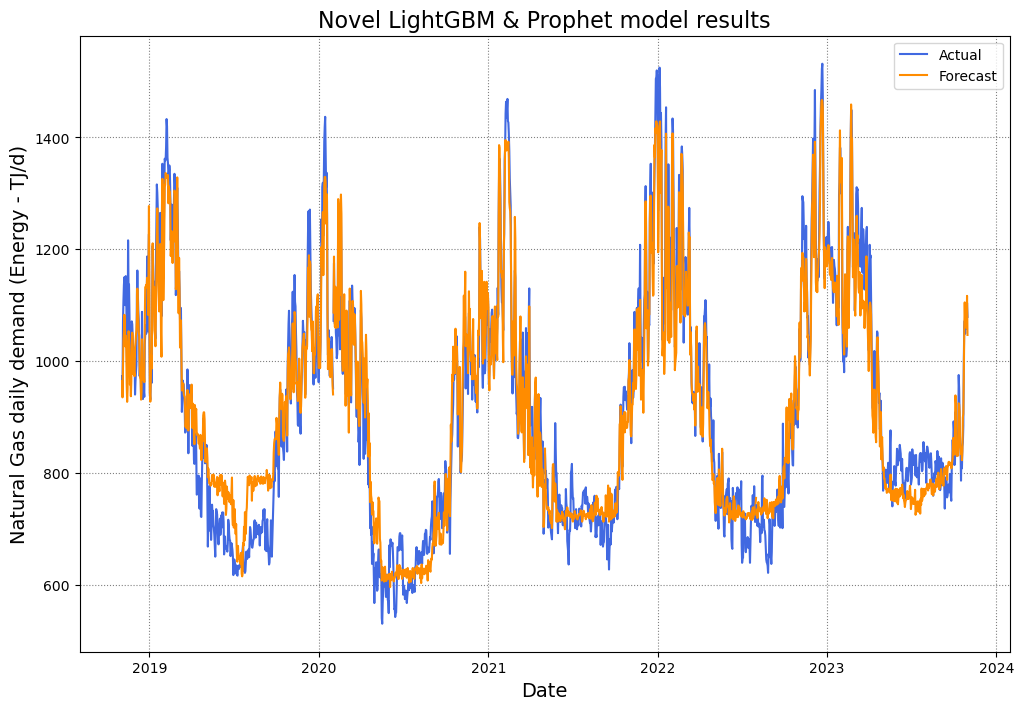


Average Metrics Over the Rolls:
Mean Absolute Error: 42.66
Mean Squared Error: 2763.31
Root Mean Squared Error: 52.11
R-squared: 0.94
Mean Absolute Percentage Error: 4.98%
Median Absolute Percentage Error: 4.10%


{'avg_mae_nlph': 42.659804310504924,
 'avg_mse_nlph': 2763.3101614221914,
 'avg_rmse_nlph': 52.11137653510297,
 'avg_r2_nlph': 0.9383951008114759,
 'avg_mape_nlph': 4.98192920897232,
 'avg_mdape_nlph': 4.099854119521415}

In [158]:
# Importing the necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

def train_time_series_with_folds_autoreg_prophet_features(df, initials=1825, period=456, horizon=456, lags=[1, 2, 3, 4, 5]): 
    # Create a dataframe containing all the new features created with Prophet
    new_prophet_features = prophet_features2(df, horizon=horizon) 

    # Check if 'level_0' already exists before resetting the index
    if 'level_0' not in df.columns:
        df.reset_index(inplace=True)

    # Convert 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Merge the Prophet features dataframe with our initial dataframe
    df = pd.merge(df, new_prophet_features, left_on=['DATE'], right_on=['ds'], how='inner') 
    df.drop(['ds'], axis=1, inplace=True)  # Drop unnecessary columns
    df.set_index('DATE', inplace=True)

    # Use Prophet predictions to create some lag variables (yhat column)
    for lag in lags: 
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag) 
    df.dropna(axis=0, how='any', inplace=True)  # Drop rows with NaN values

    # Defining the LightGBM model
    model = LGBMRegressor(random_state=42)

    # Setting up time series cross-validation with specified 4 folds
    tscv = TimeSeriesSplit(n_splits=4, max_train_size=initials, test_size=horizon, gap=0)

    # Lists to store evaluation metrics for each fold
    mae_scores, mse_scores, rmse_scores, r2_scores, mape_scores, mdape_scores = [], [], [], [], [], []

    plt.figure(figsize=(12, 8))
    plt.title('Novel LightGBM & Prophet model results', fontsize=16)

    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        X_train, X_test = df.iloc[train_index].drop('NG_DEMAND', axis=1), df.iloc[test_index].drop('NG_DEMAND', axis=1)
        y_train, y_test = df.iloc[train_index]['NG_DEMAND'], df.iloc[test_index]['NG_DEMAND']

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)

        # Evaluate performance metrics
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, predictions)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mdape = np.median(np.abs((y_test - predictions) / y_test)) * 100

        # Plot the real vs prediction for each fold
        plt.plot(df.index[test_index], y_test.values, color='royalblue', label='Actual')
        plt.plot(df.index[test_index], predictions, color='darkorange', label='Forecast')

        # Store metrics for later
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mape_scores.append(mape)
        mdape_scores.append(mdape)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=14)
   
    # Only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(linestyle=":", color='grey')
    plt.show()

    # Calculate average performance metrics
    avg_mae_nlph = np.mean(mae_scores)
    avg_mse_nlph = np.mean(mse_scores)
    avg_rmse_nlph = np.mean(rmse_scores)
    avg_r2_nlph = np.mean(r2_scores)
    avg_mape_nlph = np.mean(mape_scores)
    avg_mdape_nlph = np.mean(mdape_scores)

    print(f'\nAverage Metrics Over the Rolls:')
    print(f'Mean Absolute Error: {avg_mae_nlph:.2f}')
    print(f'Mean Squared Error: {avg_mse_nlph:.2f}')
    print(f'Root Mean Squared Error: {avg_rmse_nlph:.2f}')
    print(f'R-squared: {avg_r2_nlph:.2f}')
    print(f'Mean Absolute Percentage Error: {avg_mape_nlph:.2f}%')
    print(f'Median Absolute Percentage Error: {avg_mdape_nlph:.2f}%')

    # Return the average performance metrics
    return {
        'avg_mae_nlph': avg_mae_nlph,
        'avg_mse_nlph': avg_mse_nlph,
        'avg_rmse_nlph': avg_rmse_nlph,
        'avg_r2_nlph': avg_r2_nlph,
        'avg_mape_nlph': avg_mape_nlph,
        'avg_mdape_nlph': avg_mdape_nlph
    }

# Calling function to model the provided dataset
train_time_series_with_folds_autoreg_prophet_features(merged_df)

### 3.3 Adding Regressors to the Novel LightGBM and Prophet

23:39:30 - cmdstanpy - INFO - Chain [1] start processing
23:39:31 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5587
[LightGBM] [Info] Number of data points in the train set: 1823, number of used features: 24
[LightGBM] [Info] Start training from score 731.418541
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5863
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 24
[LightGBM] [Info] Start training from score 787.220822
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5986
[LightGBM] [Info] Number of data points in the train set: 1825, number of used features: 24
[LightGBM] [Info] Start tr

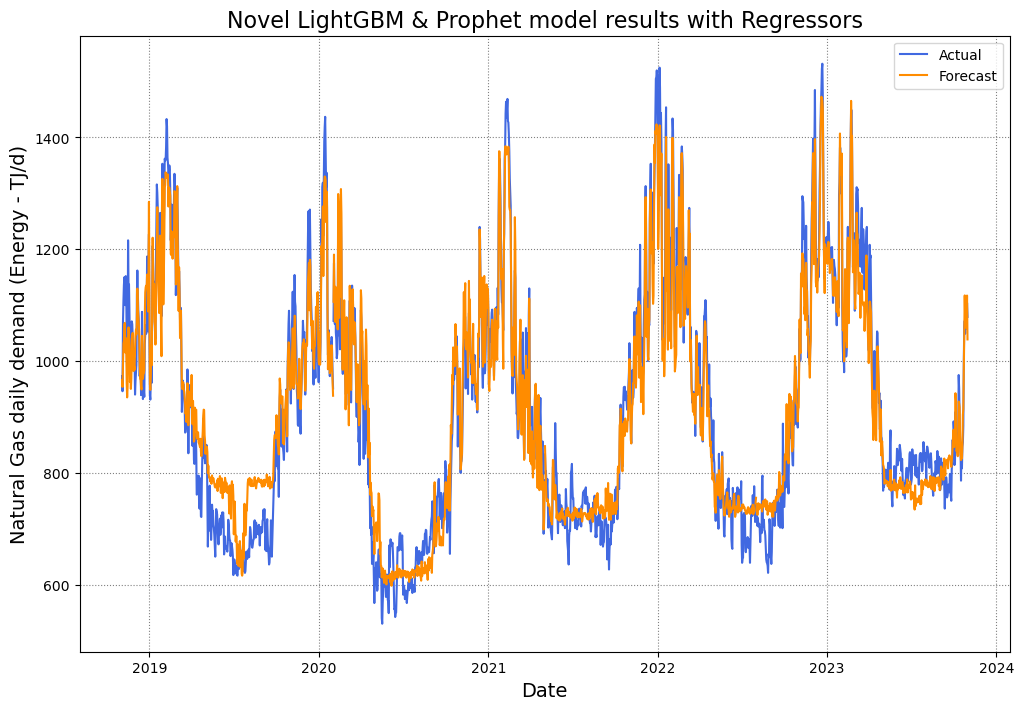


Average Metrics Over the Rolls:
Average Mean Absolute Error: 42.71
Average Mean Squared Error: 2792.53
Average Root Mean Squared Error:               52.439664
Average R-squared: 0.94
Average Mean Absolute Percentage Error: 4.990489%
Average Median Absolute Percentage Error: 4.07%


{'avg_mae_reg': 42.7137777361905,
 'avg_mse_reg': 2792.5267113552295,
 'avg_rmse_reg': 52.43966375781231,
 'avg_r2_reg': 0.9378596668373183,
 'avg_mape_reg': 4.990488503010093,
 'avg_mdape_reg': 4.072898180963526}

In [159]:
# Importing the necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def train_time_series_with_folds_autoreg_prophet_features(df, initials=1825, period=456, horizon=456, lags=[1, 2, 3, 4, 5]): 
    # Create a dataframe containing all the new features created with Prophet
    new_prophet_features = prophet_features2(df, horizon=horizon) 

    # Checking if 'level_0' already exists before resetting the index
    if 'level_0' not in df.columns:
        df.reset_index(inplace=True)

    # Converting 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Merging the Prophet features dataframe with our initial dataframe
    df = pd.merge(df, new_prophet_features, left_on=['DATE'], right_on=['ds'], how='inner') 
    df.drop(['ds'], axis=1, inplace=True)  # Drop unnecessary columns
    df.set_index('DATE', inplace=True)

    # Use Prophet predictions to create some lag variables (yhat column)
    for lag in lags: 
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag) 
    df.dropna(axis=0, how='any', inplace=True)  # Drop rows with NaN values

    # Adding additional regressors
    for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                      'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
        df[regressor] = df[regressor]

    # Defining the LightGBM model
    model = Pipeline([
        #('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with mean
        ('scaler', StandardScaler()),  # Standardize features
        ('lgbm', LGBMRegressor(random_state=42))  # LGBM model
    ])

    # Setting up time series cross-validation with specified 4 folds
    tscv = TimeSeriesSplit(n_splits=4, max_train_size=initials, test_size=horizon, gap=0)

    # Lists to store evaluation metrics for each fold
    mae_scores, mse_scores, rmse_scores, r2_scores, mape_scores, mdape_scores = [], [], [], [], [], []

    plt.figure(figsize=(12, 8))
    plt.title('Novel LightGBM & Prophet model results with Regressors', fontsize=16)

    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        X_train, X_test = df.iloc[train_index].drop('NG_DEMAND', axis=1), df.iloc[test_index].drop('NG_DEMAND', axis=1)
        y_train, y_test = df.iloc[train_index]['NG_DEMAND'], df.iloc[test_index]['NG_DEMAND']

        # Train the model
        model.fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)

        # Evaluate performance metrics
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = 1 - (mse / np.var(y_test))
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mdape = np.median(np.abs((y_test - predictions) / y_test)) * 100

        # Plot the real vs prediction for each fold
        plt.plot(df.index[test_index], y_test.values, color='royalblue', label='Actual')
        plt.plot(df.index[test_index], predictions, color='darkorange', label='Forecast')

        # Store metrics for later
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mape_scores.append(mape)
        mdape_scores.append(mdape)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=14)
    
    # Only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(linestyle=":", color='grey')
    plt.show()

    # Calculate average performance metrics
    avg_mae_reg = np.mean(mae_scores)
    avg_mse_reg = np.mean(mse_scores)
    avg_rmse_reg = np.mean(rmse_scores)
    avg_r2_reg = np.mean(r2_scores)
    avg_mape_reg = np.mean(mape_scores)
    avg_mdape_reg = np.mean(mdape_scores)

    print(f'\nAverage Metrics Over the Rolls:')
    print(f'Average Mean Absolute Error: {avg_mae_reg:.2f}')
    print(f'Average Mean Squared Error: {avg_mse_reg:.2f}')
    print(f'Average Root Mean Squared Error: {avg_rmse_reg:23f}')
    print(f'Average R-squared: {avg_r2_reg:.2f}')
    print(f'Average Mean Absolute Percentage Error: {avg_mape_reg:2f}%')
    print(f'Average Median Absolute Percentage Error: {avg_mdape_reg:.2f}%')
        
    # Return the average performance metrics
    return {
        'avg_mae_reg': avg_mae_reg,
        'avg_mse_reg': avg_mse_reg,
        'avg_rmse_reg': avg_rmse_reg,
        'avg_r2_reg': avg_r2_reg,
        'avg_mape_reg': avg_mape_reg,
        'avg_mdape_reg': avg_mdape_reg
    }

# Calling the function to model the provided dataset
train_time_series_with_folds_autoreg_prophet_features(merged_df)


### 3.4 Novel LightGBM and Prophet Hyperparameter Tuning
    """
    Train a time series model using LightGBM with cross-validation.

    Parameters:
    - df: DataFrame, input data
    - initials: int, number of initial samples for training
    - period: int, period of each fold
    - horizon: int, test horizon for each fold
    - lags: list, lag variables for autoregression
    - num_leaves: int, number of leaves for LightGBM

    Returns:
    None
    """

23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:42:01 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_gain_to_split is set=0.5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Total Bins 5863
[LightGBM] [Info] Number of data points in the train

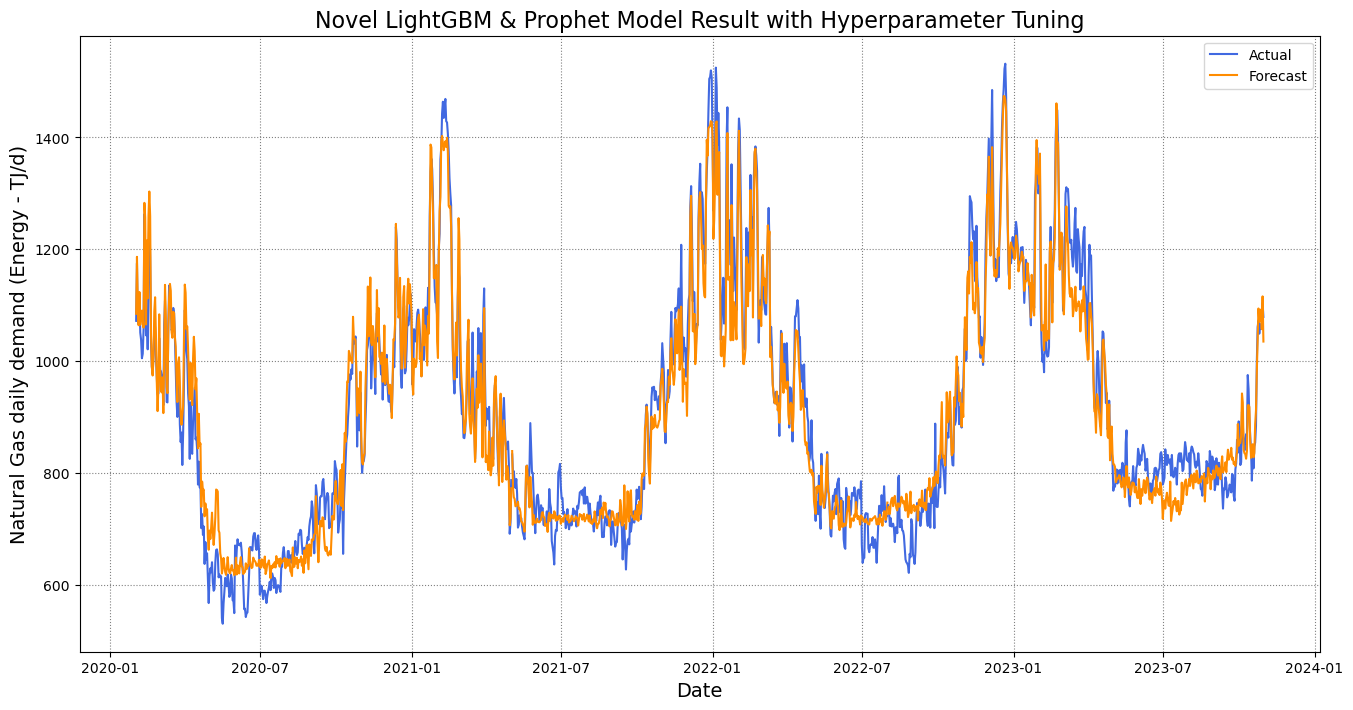


Average Metrics Over the Rolls:
Mean Absolute Error: 38.97
Mean Squared Error: 2340.88
Root Mean Squared Error: 48.32
R-squared: 0.95
Mean Absolute Percentage Error: 4.49%
Median Absolute Percentage Error: 3.90%


{'avg_mae_hyp': 38.970663264316464,
 'avg_mse_hyp': 2340.8837096407915,
 'avg_rmse_hyp': 48.31920829555266,
 'avg_r2_hyp': 0.946872638985516,
 'avg_mape_hyp': 4.4914753754887125,
 'avg_mdape_hyp': 3.897859805293367}

In [163]:
# Importing the necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def train_time_series_with_folds_autoreg_prophet_features(df, initials=1825, period=456, horizon=456, lags=[1, 2, 3, 4, 5]):
    # Creating a dataframe containing all the new features created with Prophet
    new_prophet_features = prophet_features(df, horizon=horizon)

    # Checking if 'level_0' already exists before resetting the index
    if 'level_0' not in df.columns:
        df.reset_index(inplace=True)

    # Converting 'DATE' column to datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Merging the Prophet features dataframe with our initial dataframe
    df = pd.merge(df, new_prophet_features, left_on='DATE', right_on='ds', how='inner')
    df.drop(['ds'], axis=1, inplace=True)  # Drop unnecessary columns
    df.set_index('DATE', inplace=True)

    # Using Prophet predictions to create some lag variables (yhat column)
    for lag in lags:
        df[f'yhat_lag_{lag}'] = df['yhat'].shift(lag)
    df.dropna(axis=0, how='any', inplace=True)  # Drop rows with NaN values

    # Adding additional regressors
    additional_regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
                             'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
                             'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']
    df[additional_regressors] = df[additional_regressors]

    # Defining the parameter grid for hyperparameter tuning
    param_grid = {
        'lgbm__n_estimators': [50, 100, 200],
        'lgbm__learning_rate': [0.01, 0.1, 0.2],
        'lgbm__max_depth': [5, 10, 15],
        'lgbm__lambda_l1': [0, 0.1, 0.5, 1],
        'lgbm__lambda_l2': [0, 0.1, 0.5, 1],
        'lgbm__min_gain_to_split': [0, 0.1, 0.5, 1],
        'lgbm__num_leaves': [31, 50, 100, 200]
    }

    # Defining the LightGBM model
    model = Pipeline([
        ('scaler', StandardScaler()),  # Standardize features
        ('lgbm', LGBMRegressor(force_col_wise=True,random_state=42))  # LGBM model
    ])

    # Setting up time series cross-validation with specified 3 folds
    tscv = TimeSeriesSplit(n_splits=3, max_train_size=initials, test_size=horizon, gap=0)
    
    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)

    # Lists to store evaluation metrics for each fold
    mae_scores, mse_scores, rmse_scores, r2_scores, mape_scores, mdape_scores = [], [], [], [], [], []

    plt.figure(figsize=(16, 8))
    plt.title('Novel LightGBM & Prophet Model Result with Hyperparameter Tuning', fontsize=16)

    for i, (train_index, test_index) in enumerate(tscv.split(df)):
        X_train, X_test = df.iloc[train_index].drop('NG_DEMAND', axis=1), df.iloc[test_index].drop('NG_DEMAND', axis=1)
        y_train, y_test = df.iloc[train_index]['NG_DEMAND'], df.iloc[test_index]['NG_DEMAND']

        # Train the model using GridSearchCV
        random_search.fit(X_train, y_train)

        # Get the best parameters
        best_params = random_search.best_params_

        # Make predictions using the model with the best parameters
        predictions = random_search.predict(X_test)

        # Evaluate performance metrics
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        r2 = 1 - (mse / np.var(y_test))
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mdape = np.median(np.abs((y_test - predictions) / y_test)) * 100

        # Plot the real vs prediction for each fold
        plt.plot(df.index[test_index], y_test.values, color='royalblue', label='Actual')
        plt.plot(df.index[test_index], predictions, color='darkorange', label='Forecast')

        # Store metrics for later
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        mape_scores.append(mape)
        mdape_scores.append(mdape)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=14)
    
    # Only add the legend once
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    
    plt.grid(linestyle=":", color='grey')
    plt.show()

    # Calculate average performance metrics from all the folds
    avg_mae_hyp = np.mean(mae_scores)
    avg_mse_hyp = np.mean(mse_scores)
    avg_rmse_hyp = np.mean(rmse_scores)
    avg_r2_hyp = np.mean(r2_scores)
    avg_mape_hyp = np.mean(mape_scores)
    avg_mdape_hyp = np.mean(mdape_scores)

    # Print the model performance metrics
    print(f'\nAverage Metrics Over the Rolls:')
    print(f'Mean Absolute Error: {avg_mae_hyp:.2f}')
    print(f'Mean Squared Error: {avg_mse_hyp:.2f}')
    print(f'Root Mean Squared Error: {avg_rmse_hyp:.2f}')
    print(f'R-squared: {avg_r2_hyp:.2f}')
    print(f'Mean Absolute Percentage Error: {avg_mape_hyp:.2f}%')
    print(f'Median Absolute Percentage Error: {avg_mdape_hyp:.2f}%')
        
    # Return the average performance metrics
    return {
        'avg_mae_hyp': avg_mae_hyp,
        'avg_mse_hyp': avg_mse_hyp,
        'avg_rmse_hyp': avg_rmse_hyp,
        'avg_r2_hyp': avg_r2_hyp,
        'avg_mape_hyp': avg_mape_hyp,
        'avg_mdape_hyp': avg_mdape_hyp
    }

# Calling function to model the dataset
train_time_series_with_folds_autoreg_prophet_features(merged_df)


### 3.5 Hybrid Model Evaluation

In [151]:
# Access individual metrics from the returned dictionary
avg_mae_nlph = 'avg_mae_nlph'
avg_mse_nlph = 'avg_mse_nlph'
avg_rmse_nlph = 'avg_rmse_nlph'
avg_r2_nlph = average_metrics['avg_r2_nlph']
avg_mape_nlph = average_metrics['avg_mape_nlph']
avg_mdape_nlph = average_metrics['avg_mdape_nlph']

avg_mae_reg = average_metrics['avg_mae_reg']
avg_mse_reg = average_metrics['avg_mse_reg']
avg_rmse_reg = average_metrics['avg_rmse_reg']
avg_r2_reg = average_metrics['avg_r2_reg']
avg_mape_reg = average_metrics['avg_mape_reg']
avg_mdape_reg = average_metrics['avg_mdape_reg']

avg_mae_hyp = average_metrics['avg_mae_hyp']
avg_mse_hyp = average_metrics['avg_mse_hyp']
avg_rmse_hyp = average_metrics['avg_rmse_hyp']
avg_r2_hyp = average_metrics['avg_r2_hyp']
avg_mape_hyp = average_metrics['avg_mape_hyp']
avg_mdape_hyp = average_metrics['avg_mdape_hyp']

# Define the metrics for the model
metrics_nlph = [avg_mse_nlph, avg_rmse_nlph, avg_mape_nlph, avg_mae_nlph, avg_mdape_nlph, avg_r2_nlph]
metrics_reg = [avg_mse_reg, avg_rmse_reg, avg_mape_reg, avg_mae_reg, avg_mdape_reg, avg_r2_reg]
metrics_hyp = [avg_mse_hyp, avg_rmse_hyp, avg_mape_hyp, avg_mae_hyp, avg_mdape_hyp, avg_r2_hyp]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_lgbm_prophet_metrics = pd.DataFrame({
    'LightGBM-Prophet': metrics_nlph.apply(lambda x: f'{x:.3f}'),
    'LightGBM-Prophet with Regressors': metrics_reg.apply(lambda x: f'{x:.3f}'),
    'Improved LightGBM-Prophet': metrics_hyp.apply(lambda x: f'{x:.3f}')
}, index=labels)

df_lgbm_prophet_metrics.head(10)

NameError: name 'average_metrics' is not defined

### Hybrid Model Evaluation


In [144]:
# Define the metrics for the model
metrics_base = [mse, rmse, mape, mae, mdape, r2]
metrics_cv = [mse_cv, rmse_cv, mape_cv, mae_cv, mdape_cv, r2_cv]
metrics_hy = [mse_hy, rmse_hy, mape_hy, mae_hy, mdape_hy, r2_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_metrics = pd.DataFrame({'Base Model': metrics_base, 'Cross-Validation': metrics_cv, 'Improved-Prophet': metrics_hy}, index=labels)

df_metrics.head(10)

,Base Model,Cross-Validation,Improved-Prophet
MSE,9308.800846,2920.110663,2920.110663
RMSE,96.482127,54.038048,54.038048
MAPE,9.083198,5.072586,5.072586
MAE,85.202092,43.304708,43.304708
MDAPE,8.651511,4.122213,4.122213
R-squared,0.801151,0.935974,0.935974


- In summary, the Improved-Prophet model performs the best in terms of MSE, MAE, MAPE, MDAPE, and R-squared, which means using grid search, we fine fine-tune the model's hyperparameters to achieve better forecasting performance.
- The presence of NaN values in MAPE and MDAPE for the Base Model might indicate some issues with the predictions (like predicting zero values). It would be worth investigating this further.
- The Cross-Validation model performs slightly better in terms of RMSE. It’s important to consider all these metrics together when evaluating the performance of the models.r.

## SARIMAX Model 

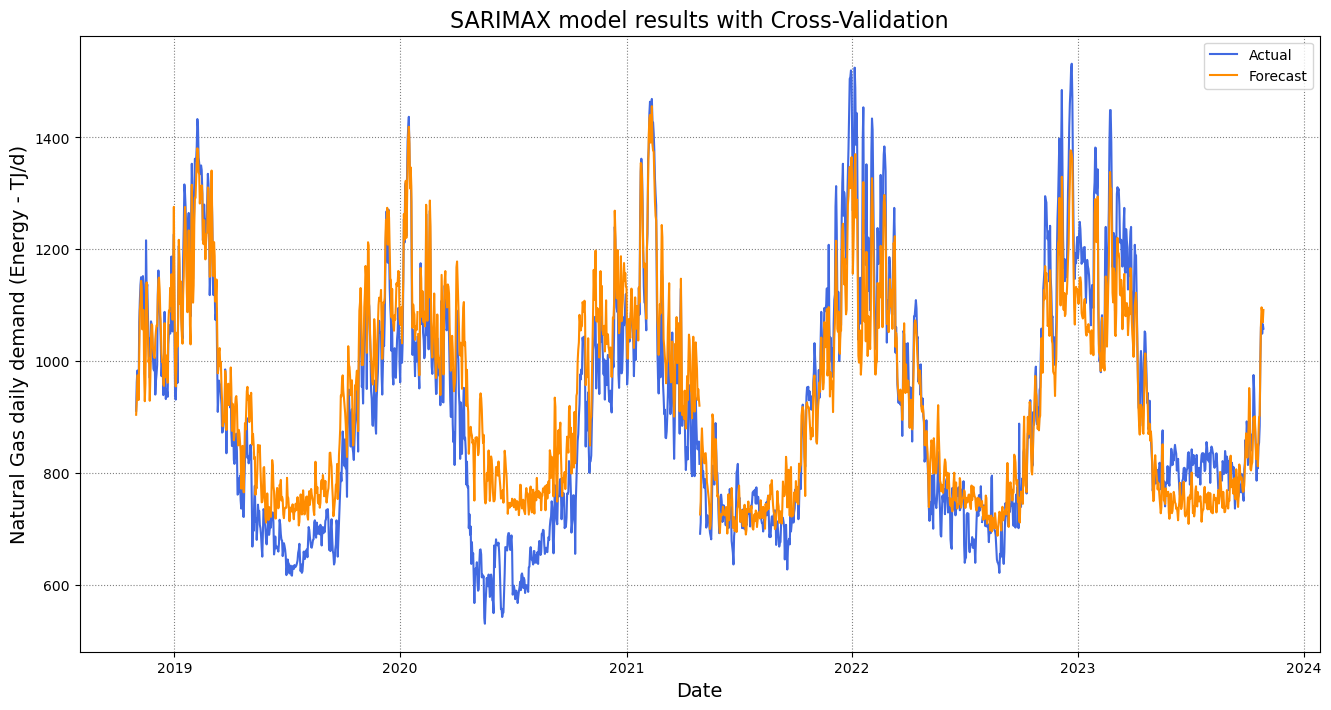


Average Metrics Over the Rolls:
Mean Squared Error: 6499.016
Root Mean Squared Error: 78.180
Mean Absolute Percentage Error: 7.801%
Mean Absolute Error: 64.674
Median Absolute Percentage Error: 6.391%
R-squared: 0.853


In [475]:
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order = (1, 1, 1), seasonal_order= (1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=True, maxiter=10)
        return self

    def predict(self, X):
        forecast_steps = X.shape[0]
        return self.results.get_forecast(steps=forecast_steps, exog=X).predicted_mean

# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['DATE', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
               'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
               'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Define training and test set sizes
initials = 1825
horizon = 456

# Initialize the total performance metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Create a figure before the loop
plt.figure(figsize=(16, 8))

# Define the pipeline
pipeline = Pipeline([
    ('sarimax', SARIMAXWrapper(order=order, seasonal_order=seasonal_order))
])

# Perform time series cross-validation with rolling basis
for i in range(4):
    # Split the data into training and test sets
    train_end = initials + i * horizon
    test_start = train_end
    test_end = test_start + horizon

    X_train, X_test = X.iloc[:train_end], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:train_end], y.iloc[test_start:test_end]

    # Fit SARIMA model with exogenous variables
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")  # Ignore convergence warnings
        pipeline.fit(X_train.drop(columns=['DATE']), y_train)

    # Forecast future values
    y_pred = pipeline.predict(X_test.drop(columns=['DATE']))

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    # Add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

    # Plot the forecast and actuals with the DATE column
    plt.plot(X_test['DATE'], y_test, color='royalblue', label='Actual')
    plt.plot(X_test['DATE'], y_pred, color='darkorange', label='Forecast')

# Add title, labels, and legend after the loop
plt.title('SARIMAX model results with Cross-Validation', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=14)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate the average performance metrics
mse_sarimax_cv = total_mse / 4
rmse_sarimax_cv = total_rmse / 4
mape_sarimax_cv = total_mape / 4
mae_sarimax_cv = total_mae / 4
mdape_sarimax_cv = total_mdape / 4
r2_sarimax_cv = total_r2 / 4

# Print the results
print(f'\nAverage Metrics Over the Rolls:')
print(f'Mean Squared Error: {mse_sarimax_cv:.3f}')
print(f'Root Mean Squared Error: {rmse_sarimax_cv:.3f}')
print(f'Mean Absolute Percentage Error: {mape_sarimax_cv:.3f}%')
print(f'Mean Absolute Error: {mae_sarimax_cv:.3f}')
print(f'Median Absolute Percentage Error: {mdape_sarimax_cv:.3f}%')
print(f'R-squared: {r2_sarimax_cv:.3f}')

### Hyperparameter Tuning

C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


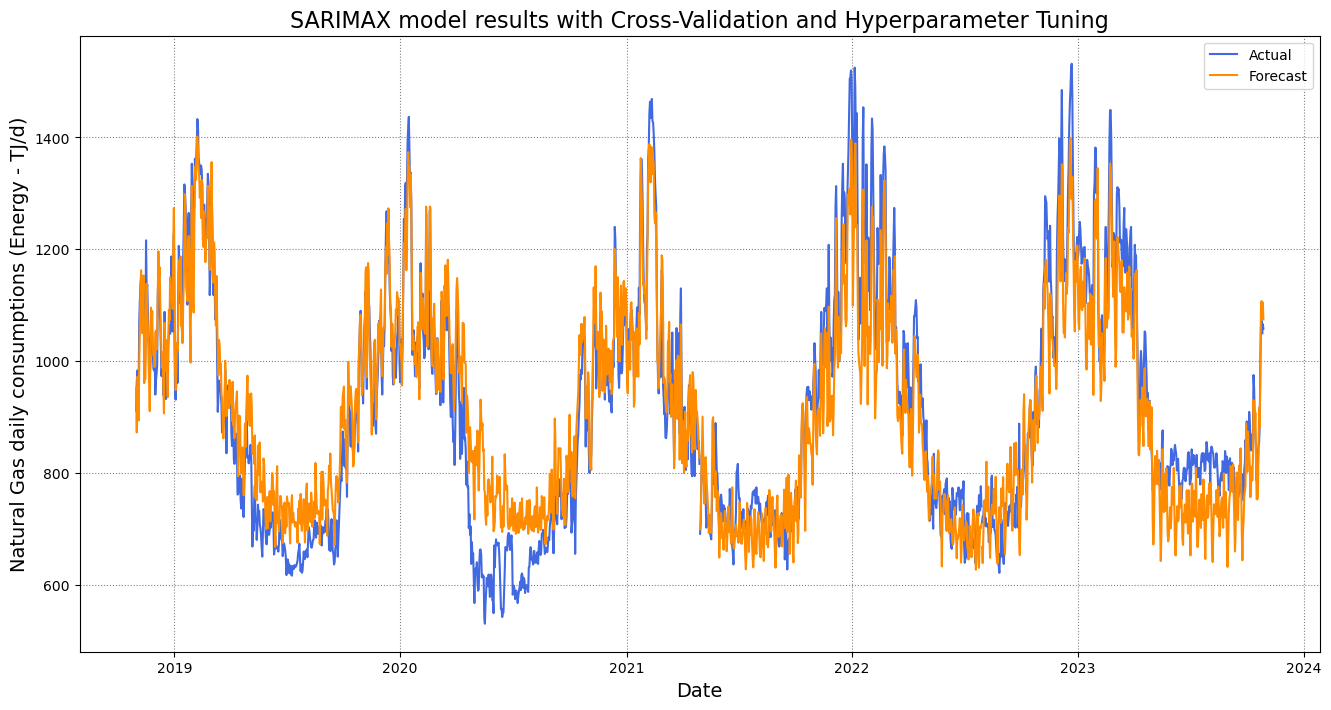


Average Metrics Over the Rolls:
Mean Squared Error: 6199.178
Root Mean Squared Error: 78.128
Mean Absolute Percentage Error: 7.397%
Mean Absolute Error: 62.887
Median Absolute Percentage Error: 5.997
R-squared: 0.861


In [476]:
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'DATE' is in string format, convert it to datetime
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=True, maxiter=10)
        return self

    def predict(self, X):
        forecast_steps = X.shape[0]
        return self.results.get_forecast(steps=forecast_steps, exog=X).predicted_mean

# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['DATE', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
               'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
               'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Convert 'DATE' to datetime
X['DATE'] = pd.to_datetime(X['DATE'])

# Define training and test set sizes
initials = 1825
horizon = 456

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=4)  # Adjust the number of splits as needed

# Define a pipeline combining feature selection and SARIMAX model
pipe = Pipeline([
    ('select_best', SelectKBest(score_func=f_regression)),
    ('sarimax', SARIMAXWrapper())
])

# Define a smaller grid of hyperparameters
param_grid = {
    'select_best__k': range(1, len(X.columns) + 1),
    'sarimax__order': [(p, d, q) for p in range(2) for d in range(2) for q in range(2)],
    'sarimax__seasonal_order': [(P, D, Q, S) for P in range(2) for D in range(2) for Q in range(2) for S in [12]]
}

# Set up a randomized search with cross-validation
grid = RandomizedSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=100)
grid.fit(X.drop(columns=['DATE']), y)

# Get the best model
best_model = grid.best_estimator_

# Perform time series cross-validation with rolling basis using the best model
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Create a figure before the loop
plt.figure(figsize=(16, 8))

# Perform time series cross-validation with rolling basis using the best model
for i in range(4):
    # Split the data into training and test sets
    train_end = initials + i * horizon
    test_start = train_end
    test_end = test_start + horizon

    X_train, X_test = X.iloc[:train_end], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:train_end], y.iloc[test_start:test_end]

    # Fit SARIMA model with exogenous variables using the best model
    best_model.fit(X_train.drop(columns=['DATE']), y_train)

    # Forecast future values
    y_pred = best_model.predict(X_test.drop(columns=['DATE']))

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    # Add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

    # Plot the forecast and actuals
    plt.plot(X_test['DATE'], y_test, color='royalblue', label='Actual')
    plt.plot(X_test['DATE'], y_pred, color='darkorange', label='Forecast')

# Add title, labels, and legend after the loop
plt.title('SARIMAX model results with Cross-Validation and Hyperparameter Tuning', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Natural Gas daily consumptions (Energy - TJ/d)', fontsize=14)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate the average performance metrics
mse_sarimax_hy = total_mse / n_splits
rmse_sarimax_hy = total_rmse / n_splits
mape_sarimax_hy = total_mape / n_splits
mae_sarimax_hy = total_mae / n_splits
mdape_sarimax_hy = total_mdape / n_splits
r2_sarimax_hy = total_r2 / n_splits

# Print the results
print(f'\nAverage Metrics Over the Rolls:')
print(f'Mean Squared Error: {mse_sarimax_hy:.3f}')
print(f'Root Mean Squared Error: {rmse_sarimax_hy:.3f}')
print(f'Mean Absolute Percentage Error: {mape_sarimax_hy:.3f}%')
print(f'Mean Absolute Error: {mae_sarimax_hy:.3f}')
print(f'Median Absolute Percentage Error: {mdape_sarimax_hy:.3f}%')
print(f'R-squared: {r2_sarimax_hy:.3f}')


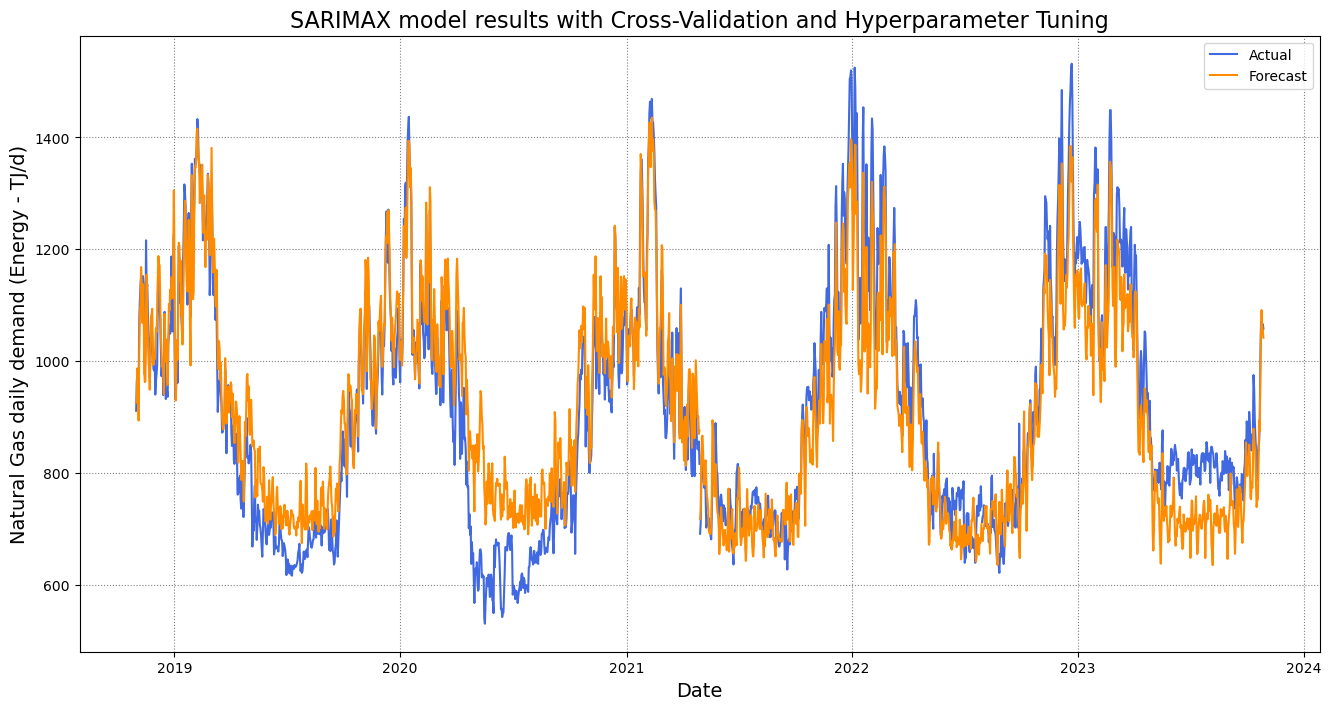


Average Metrics Over the Rolls:
Mean Squared Error: 6264.829
Root Mean Squared Error: 77.821
Mean Absolute Percentage Error: 7.552%
Mean Absolute Error: 63.828
Median Absolute Percentage Error: 6.200
R-squared: 0.858


In [477]:
import warnings
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'DATE' is in string format, convert it to datetime
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'])

class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), maxiter=50):
        self.order = order
        self.seasonal_order = seasonal_order
        self.maxiter = maxiter
        self.model = None

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=True, maxiter=self.maxiter)
        return self

    def predict(self, X):
        forecast_steps = X.shape[0]
        return self.results.get_forecast(steps=forecast_steps, exog=X).predicted_mean

# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['DATE', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
               'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
               'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Convert 'DATE' to datetime
X['DATE'] = pd.to_datetime(X['DATE'])

# Define training and test set sizes
initials = 1825
horizon = 456

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=4)  # Adjust the number of splits as needed

# Define a pipeline combining feature scaling, selection and SARIMAX model
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('select_best', SelectKBest(score_func=f_regression)),
    ('sarimax', SARIMAXWrapper())
])

# Define a smaller grid of hyperparameters
param_grid = {
    'select_best__k': range(1, len(X.columns) + 1),
    'sarimax__order': [(p, d, q) for p in range(2) for d in range(2) for q in range(2)],
    'sarimax__seasonal_order': [(P, D, Q, S) for P in range(2) for D in range(2) for Q in range(2) for S in [12]],
    'sarimax__maxiter': [50, 100, 150]
}

# Set up a randomized search with cross-validation
grid = RandomizedSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=150)
grid.fit(X.drop(columns=['DATE']), y)

# Get the best model
best_model = grid.best_estimator_

# Perform time series cross-validation with rolling basis using the best model
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Create a figure before the loop
plt.figure(figsize=(16, 8))

# Perform time series cross-validation with rolling basis using the best model
for i in range(4):
    # Split the data into training and test sets
    train_end = initials + i * horizon
    test_start = train_end
    test_end = test_start + horizon

    X_train, X_test = X.iloc[:train_end], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:train_end], y.iloc[test_start:test_end]

    # Fit SARIMA model with exogenous variables using the best model
    best_model.fit(X_train.drop(columns=['DATE']), y_train)

    # Forecast future values
    y_pred = best_model.predict(X_test.drop(columns=['DATE']))

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    mae = mean_absolute_error(y_test, y_pred)
    mdape = np.median(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    # Add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

    # Plot the forecast and actuals
    plt.plot(X_test['DATE'], y_test, color='royalblue', label='Actual')
    plt.plot(X_test['DATE'], y_pred, color='darkorange', label='Forecast')

# Add title, labels, and legend after the loop
plt.title('SARIMAX model results with Cross-Validation and Hyperparameter Tuning', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Natural Gas daily demand (Energy - TJ/d)', fontsize=14)

# Only add the legend once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid(linestyle=":", color='grey')
plt.show()

# Calculate the average performance metrics
mse_sarimax_hy = total_mse / 4
rmse_sarimax_hy = total_rmse / 4
mape_sarimax_hy = total_mape / 4
mae_sarimax_hy = total_mae / 4
mdape_sarimax_hy = total_mdape / 4
r2_sarimax_hy = total_r2 / 4

# Print the results
print(f'\nAverage Metrics Over the Rolls:')
print(f'Mean Squared Error: {mse_sarimax_hy:.3f}')
print(f'Root Mean Squared Error: {rmse_sarimax_hy:.3f}')
print(f'Mean Absolute Percentage Error: {mape_sarimax_hy:.3f}%')
print(f'Mean Absolute Error: {mae_sarimax_hy:.3f}')
print(f'Median Absolute Percentage Error: {mdape_sarimax_hy:.3f}')
print(f'R-squared: {r2_sarimax_hy:.3f}')


In [50]:
from statsmodels.tsa.stattools import adfuller
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(merged_df['NG_DEMAND'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -3.650559
p-value                           0.004865
#Lags Used                       13.000000
Number of Observations Used    3638.000000
Critical Value (1%)              -3.432149
Critical Value (5%)              -2.862335
Critical Value (10%)             -2.567193
dtype: float64


In [89]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Custom wrapper for SARIMAX to use with sklearn
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model = None

    def fit(self, X, y):
        self.model = SARIMAX(y, exog=X, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=True, maxiter=120, warn_convergence=False)  # Set warn_convergence to False
        return self

    def predict(self, X):
        return self.results.get_forecast(steps=X.shape[0], exog=X).predicted_mean

# Choose the target variable (NG_DEMAND in this case) and independent variables
y = merged_df['NG_DEMAND']
X = merged_df[['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
        'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
        'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']]

# Set up cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # Adjust the number of splits as needed

# Define a pipeline combining feature selection and SARIMAX model
pipe = Pipeline([
    ('select_best', SelectKBest(score_func=f_regression)),
    ('sarimax', SARIMAXWrapper())
])

# Define a smaller grid of hyperparameters
param_grid = {
    'select_best__k': range(1, len(X.columns) + 1),
    'sarimax__order': [(p, d, q) for p in range(2) for d in range(2) for q in range(2)],
    'sarimax__seasonal_order': [(P, D, Q, S) for P in range(2) for D in range(2) for Q in range(2) for S in [12]]
}

# Set up a randomized search with cross-validation
grid = RandomizedSearchCV(pipe, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, n_iter=120)

# Perform cross-validation
for train_index, test_index in tscv.split(X):
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]

    # Fit and search for the best parameters
    grid.fit(X_train, y_train)

    # Get the best model
    model = grid.best_estimator_

    # Forecast future values
    forecast_steps = len(y_test)  # Ensure we only forecast as many steps as there are in the test set
    forecast = model.predict(X_test[:forecast_steps])  # Use only as many exogenous variables as there are steps to forecast

    # Store actual and predicted values
    actual_values.extend(y_test)
    predicted_values.extend(forecast)

# Calculate and print additional performance metrics
mae_sa = mean_absolute_error(actual_values, predicted_values)
mse_sa = mean_squared_error(actual_values, predicted_values)
rmse_sa = np.sqrt(mse)
r2_sa = r2_score(actual_values, predicted_values)
mape_sa = mean_absolute_percentage_error(actual_values, predicted_values) * 100
medape_sa = (median_absolute_error(actual_values, predicted_values) / np.median(actual_values)) * 100

print(f'Mean Absolute Error: {mae_sa:.2f}')
print(f'Mean Squared Error: {mse_sa:.2f}')
print(f'Root Mean Squared Error: {rmse_sa:.2f}')
print(f'R-squared: {r2_sa:.2f}')
print(f'Mean Absolute Percentage Error: {mape_sa:.2f}%')
print(f'Median Absolute Percentage Error: {medape_sa:.2f}%')

# Plot the results
#plt.figure(figsize=(10, 6))
#plt.plot(merged_df.index[-len(predicted_values):], y[-len(predicted_values):], label='Actual')
#plt.plot(merged_df.index[-len(predicted_values):], predicted_values, color='red', label='Predicted')
#plt.title('SARIMA Model with Exogenous Variables, Cross-Validation, and Hyperparameter Tuning')
#plt.xlabel('Date')
#plt.ylabel('NG_DEMAND')
#plt.legend()
#plt.show()


Mean Absolute Error: 65.42
Mean Squared Error: 6578.86
Root Mean Squared Error: 89.23
R-squared: 0.87
Mean Absolute Percentage Error: 8.13%
Median Absolute Percentage Error: 7.05%


## Long Short-Term Memory (LSTM) Model
LSTMs are a type of Recurrent Neural Network (RNN) designed to handle time series data by allowing information to persist over multiple time steps.

### LSTM model with Train-test Split

Training set shape: (2922, 11)
Testing set shape: (730, 11)
Epoch 1/10
92/92 [==============================] - 17s 43ms/step - loss: 0.6403 - val_loss: 0.2041
Epoch 2/10
92/92 [==============================] - 1s 9ms/step - loss: 0.0881 - val_loss: 0.0334
Epoch 3/10
92/92 [==============================] - 1s 9ms/step - loss: 0.0182 - val_loss: 0.0126
Epoch 4/10
92/92 [==============================] - 1s 10ms/step - loss: 0.0094 - val_loss: 0.0108
Epoch 5/10
92/92 [==============================] - 1s 8ms/step - loss: 0.0074 - val_loss: 0.0080
Epoch 6/10
92/92 [==============================] - 1s 9ms/step - loss: 0.0068 - val_loss: 0.0090
Epoch 7/10
92/92 [==============================] - 1s 9ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 8/10
92/92 [==============================] - 1s 9ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 9/10
92/92 [==============================] - 1s 9ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 10/10
23/23 [==============================] - 2s

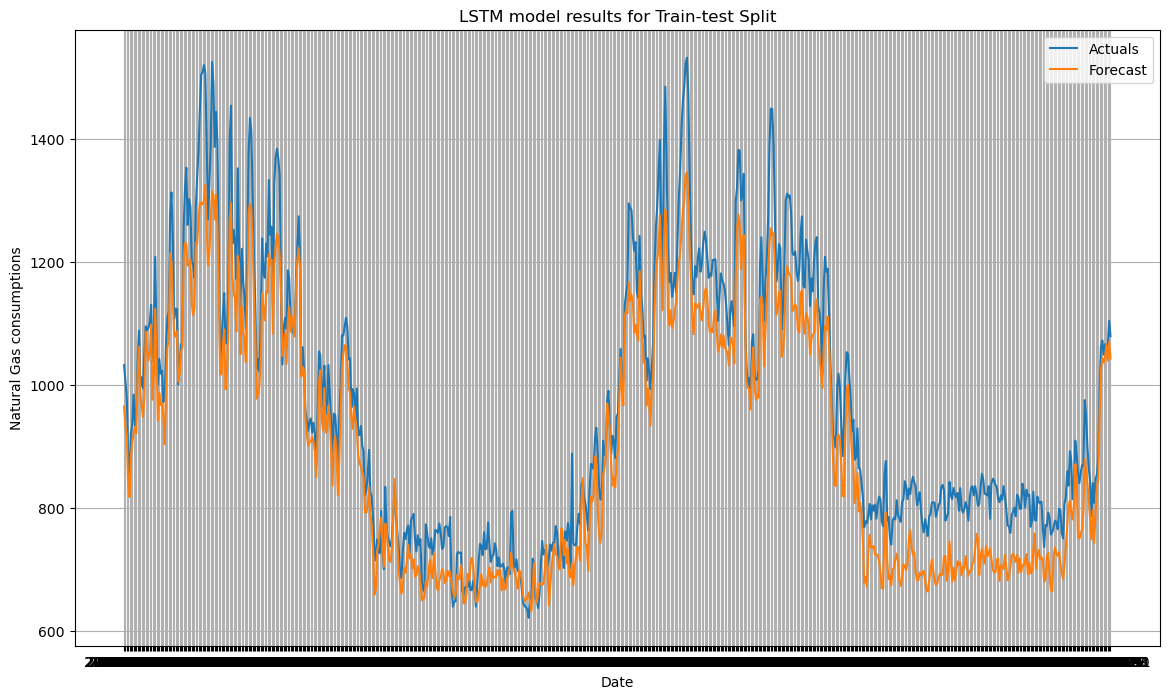

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Copying the clean DataFrame named merged_df
df_copy = merged_df.copy()

# Separate the 'DATE' column
date_column = df_copy['DATE']
df_copy = df_copy.drop(['DATE'], axis=1)

# Time Series Train-test split
test_split = round(len(df_copy) * 0.20)
df_for_training = df_copy[:-test_split]
df_for_testing = df_copy[-test_split:]
date_for_testing = date_column[-test_split:]  # Keep the dates for the testing set

print(f"Training set shape: {df_for_training.shape}")
print(f"Testing set shape: {df_for_testing.shape}")

# Scaling the training and testing data split
scaler = MinMaxScaler(feature_range=(0, 1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)

# Scaled DataFrame of features and target
trainX, trainY = df_for_training_scaled, df_for_training_scaled[:, 0]  # Assuming NG_DEMAND is the first column
testX, testY = df_for_testing_scaled, df_for_testing_scaled[:, 0]  # Assuming NG_DEMAND is the first column

# LSTM design model 
def build_model():
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(1, df_copy.shape[1])))  # Adjusted for all features
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    return model

# Build model
model = build_model()

# Fit the model 
history = model.fit(np.expand_dims(trainX, axis=1), trainY, epochs=10, validation_data=(np.expand_dims(testX, axis=1), testY))

# Use trained model to make predictions
prediction_copies_array = np.repeat(model.predict(np.expand_dims(testX, axis=1)), df_copy.shape[1], axis=-1)  # Adjusted for all features
pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(testX), df_copy.shape[1])))[:, 0]  # Assuming NG_DEMAND is the first column

# Modify results to original values
original_copies_array = np.repeat(testY, df_copy.shape[1], axis=-1)  # Adjusted for all features
original = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), df_copy.shape[1])))[:, 0]  # Assuming NG_DEMAND is the first column

# Calculate performance metrics
mse_lstm = mean_squared_error(original, pred)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(original, pred)
mape_lstm = np.mean(np.abs((original - pred) / original)) * 100
mdape_lstm = np.median(np.abs((original - pred) / original)) * 100
r2_lstm = r2_score(original, pred)

print(f"Mean Squared Error: {mse_lstm:.3f}")
print(f"Root Mean Squared Error: {rmse_lstm:.3f}")
print(f"Mean Absolute Error: {mae_lstm:.3f}")
print(f"Mean Absolute Percentage Error: {mape_lstm:.3f}%")
print(f"Median Absolute Percentage Error: {mdape_lstm:.3f}%")
print(f"R-squared: {r2_lstm:.3f}")

# Plotting
plt.figure(figsize=(14,8))
plt.plot(date_for_testing, original, label='Actuals')
plt.plot(date_for_testing, pred, label='Forecast')
plt.title('LSTM model results for Train-test Split')
plt.xlabel('Date')
plt.ylabel('Natural Gas consumptions')
plt.grid()
plt.legend()
plt.show()


### LSTM Model with Cross-Validation

In [92]:
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Let's start by assuming that df is your DataFrame
df = merged_df.copy()

# We'll remove the 'DATE' column
df.drop(columns=['DATE'], inplace=True)

# Next, we'll normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])

scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
    
# We'll define the initial period, period, and horizon (all in days) for cross-validation
initial, period, horizon = 1825, 456, 456

# We'll calculate the number of splits for TimeSeriesSplit
n_splits = (len(scaled_df) - initial) // period

# Now, we'll create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=initial + period)

# We'll initialize the total performance metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# We'll perform time series cross-validation with rolling basis using the best model
for i in range(4):
    # We'll split the data into training and test sets
    train_end = initial + i * period
    test_start = train_end
    test_end = test_start + horizon

    # We'll define the training and test data
    train = scaled_df[:train_end]
    test = scaled_df[test_start:test_end]

    # Reshape the data for LSTM [samples, timesteps, features]
    trainX, trainY = create_dataset(train)
    testX, testY = create_dataset(test)

    # Initialize the model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))   # Add the first LSTM layer
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(1))    # Add the output layer
    model.compile(loss='mean_squared_error', optimizer='adam')     # Compile the model

    # We'll fit the model (with more epochs and without a batch size)
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
    
    # We'll make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # We'll invert the predictions back to the original scale
    trainPredict = scaler_y.inverse_transform(trainPredict)
    trainY = scaler_y.inverse_transform([trainY])
    testPredict = scaler_y.inverse_transform(testPredict)
    testY = scaler_y.inverse_transform([testY])

    # We'll calculate performance metrics
    mse = mean_squared_error(testY[0], testPredict[:,0])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(testY[0], testPredict[:,0])
    mape = np.mean(np.abs((testY[0] - testPredict[:,0]) / testY[0])) * 100
    mdape = np.median(np.abs((testY[0] - testPredict[:,0]) / testY[0])) * 100
    r2 = r2_score(testY[0], testPredict[:,0])

    # We'll add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

# We'll calculate the average performance metrics
mse_lstm_cv = total_mse / n_splits
rmse_lstm_cv  = total_rmse / n_splits
mape_lstm_cv  = total_mape / n_splits
mae_lstm_cv  = total_mae / n_splits
mdape_lstm_cv  = total_mdape / n_splits
r2_lstm_cv  = total_r2 / n_splits

# Finally, we'll print the results
print(f'\nAverage Metrics Over the Rolls:')
print(f'Mean Squared Error: {mse_lstm_cv:.3f}')
print(f'Root Mean Squared Error: {rmse_lstm_cv:.3f}')
print(f'Mean Absolute Percentage Error: {mape_lstm_cv:.3f}%')
print(f'Median Absolute Percentage Error: {mdape_lstm_cv:.3f}%')
print(f'Mean Absolute Error: {mae_lstm_cv:.3f}')
print(f'R-squared: {r2_lstm_cv:.3f}')

Epoch 1/10
1823/1823 - 17s - loss: 0.0484 - 17s/epoch - 9ms/step
Epoch 2/10
1823/1823 - 9s - loss: 0.0080 - 9s/epoch - 5ms/step
Epoch 3/10
1823/1823 - 8s - loss: 0.0064 - 8s/epoch - 4ms/step
Epoch 4/10
1823/1823 - 7s - loss: 0.0059 - 7s/epoch - 4ms/step
Epoch 5/10
1823/1823 - 7s - loss: 0.0050 - 7s/epoch - 4ms/step
Epoch 6/10
1823/1823 - 7s - loss: 0.0048 - 7s/epoch - 4ms/step
Epoch 7/10
1823/1823 - 7s - loss: 0.0046 - 7s/epoch - 4ms/step
Epoch 8/10
1823/1823 - 7s - loss: 0.0046 - 7s/epoch - 4ms/step
Epoch 9/10
1823/1823 - 7s - loss: 0.0044 - 7s/epoch - 4ms/step
Epoch 10/10
1823/1823 - 7s - loss: 0.0040 - 7s/epoch - 4ms/step
15/15 [==============================] - 0s 3ms/step
Epoch 1/10
2279/2279 - 18s - loss: 0.0405 - 18s/epoch - 8ms/step
Epoch 2/10
2279/2279 - 9s - loss: 0.0075 - 9s/epoch - 4ms/step
Epoch 3/10
2279/2279 - 9s - loss: 0.0065 - 9s/epoch - 4ms/step
Epoch 4/10
2279/2279 - 9s - loss: 0.0060 - 9s/epoch - 4ms/step
Epoch 5/10
2279/2279 - 9s - loss: 0.0054 - 9s/epoch - 4ms/st

### LSTM model with Cross-Validation and Hyperparameter Tuning (Improved-LSTM)

In [90]:
import pandas as pd
import numpy as np
from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from kerastuner.tuners import RandomSearch

# Assuming df is your DataFrame
df = merged_df.copy()

# Drop the 'DATE' column
df = df.drop(columns=['DATE'])

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])

scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)

# Function to reshape dataset for LSTM
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset)):
        a = dataset[i:(i+1), :]  # Modified to include i+1 for correct slicing
        dataX.append(a)
        dataY.append(dataset[i, 0])
    return np.array(dataX), np.array(dataY)
    
# Define the initial period, period, and horizon (all in days) for cross-validation
initial, period, horizon = 1825, 456, 456

# Calculate the number of splits for TimeSeriesSplit
n_splits = (len(scaled_df) - initial) // period

# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=initial + period)

# Define a function to create the model
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', 32, 512, 32), activation='relu', input_shape=(None, 11), 
                   recurrent_dropout=hp.Float('recurrent_dropout', 0, 0.5, step=0.1),
                   recurrent_regularizer=l2(0.01), kernel_regularizer=l2(0.01)))  # Add L2 regularization
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))  # Add dropout layer
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=hp.Choice('optimizer', ['adam', 'sgd']))
    return model

# Initialize the tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='output',
    project_name='LSTM_Tuning')

# Initialize total metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Perform time series cross-validation with rolling basis using the best model
for i in range(4):
    # Split the data into training and test sets
    train_end = initial + i * period
    test_start = train_end
    test_end = test_start + horizon

    # Define the training and test data
    train = scaled_df[:train_end]
    test = scaled_df[test_start:test_end]

    # Reshape the data for LSTM [samples, timesteps, features]
    trainX, trainY = create_dataset(train)
    testX, testY = create_dataset(test)

    # Search for the best hyperparameters
    tuner.search(trainX, trainY, epochs=10, validation_data=(testX, testY))
    
    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"\nBest hyperparameters found: \nUnits: {best_hps.get('units')}, \nDropout: {best_hps.get('dropout')}, \nOptimizer: {best_hps.get('optimizer')}")

    # Build the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hps)

    # Fit the model
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

    # Make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)

    # Invert the predictions back to the original scale
    trainPredict = scaler_y.inverse_transform(trainPredict)
    trainY = scaler_y.inverse_transform([trainY])
    testPredict = scaler_y.inverse_transform(testPredict)
    testY = scaler_y.inverse_transform([testY])

    # Calculate performance metrics
    mse = mean_squared_error(testY[0], testPredict[:,0])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(testY[0], testPredict[:,0])
    mape = np.mean(np.abs((testY[0] - testPredict[:,0]) / testY[0])) * 100
    mdape = np.median(np.abs((testY[0] - testPredict[:,0]) / testY[0])) * 100
    r2 = r2_score(testY[0], testPredict[:,0])

    # Add the metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

# Calculate the average metrics
mse_lstm_hy = total_mse / n_splits
rmse_lstm_hy = total_rmse / n_splits
mape_lstm_hy = total_mape / n_splits
mae_lstm_hy = total_mae / n_splits
mdape_lstm_hy = total_mdape / n_splits
r2_lstm_hy = total_r2 / n_splits

# Print the average results
print(f'\nAverage Metrics Over the Rolls:')
print(f'Mean Squared Error: {mse_lstm_hy:.3f}')
print(f'Root Mean Squared Error: {rmse_lstm_hy:.3f}')
print(f'Mean Absolute Error: {mae_lstm_hy:.3f}')
print(f'Mean Absolute Percentage Error: {mape_lstm_hy:.3f}%')
print(f'Median Absolute Percentage Error: {mdape_lstm_hy:.3f}%')
print(f'R-squared: {r2_lstm_hy:.3f}')

Reloading Tuner from output\LSTM_Tuning\tuner0.json

Best hyperparameters found: 
Units: 224, 
Dropout: 0.4, 
Optimizer: adam
Epoch 1/10
1825/1825 - 12s - loss: 0.0418 - 12s/epoch - 7ms/step
Epoch 2/10
1825/1825 - 8s - loss: 0.0082 - 8s/epoch - 4ms/step
Epoch 3/10
1825/1825 - 8s - loss: 0.0072 - 8s/epoch - 4ms/step
Epoch 4/10
1825/1825 - 8s - loss: 0.0067 - 8s/epoch - 4ms/step
Epoch 5/10
1825/1825 - 8s - loss: 0.0068 - 8s/epoch - 4ms/step
Epoch 6/10
1825/1825 - 8s - loss: 0.0064 - 8s/epoch - 4ms/step
Epoch 7/10
1825/1825 - 8s - loss: 0.0063 - 8s/epoch - 4ms/step
Epoch 8/10
1825/1825 - 8s - loss: 0.0063 - 8s/epoch - 4ms/step
Epoch 9/10
1825/1825 - 8s - loss: 0.0063 - 8s/epoch - 4ms/step
Epoch 10/10
1825/1825 - 8s - loss: 0.0062 - 8s/epoch - 4ms/step
15/15 [==============================] - 0s 4ms/step

Best hyperparameters found: 
Units: 224, 
Dropout: 0.4, 
Optimizer: adam
Epoch 1/10
2281/2281 - 14s - loss: 0.0360 - 14s/epoch - 6ms/step
Epoch 2/10
2281/2281 - 11s - loss: 0.0078 - 11s/e

In [93]:
# Define the metrics for the model
metrics_lstm_base = [mse_lstm, rmse_lstm, mape_lstm, mae_lstm, mdape_lstm, r2_lstm]
metrics_lstm_cv = [mse_lstm_cv, rmse_lstm_cv, mape_lstm_cv, mae_lstm_cv, mdape_lstm_cv, r2_lstm_cv]
metrics_lstm_hy = [mse_lstm_hy, rmse_lstm_hy, mape_lstm_hy, mae_lstm_hy, mdape_lstm_hy, r2_lstm_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_metrics_lstm = pd.DataFrame({'Base LSTM': metrics_lstm_base, 'Cross-Validation LSTM': metrics_lstm_cv, 'Improved-LSTM': metrics_lstm_hy}, index=labels)

df_metrics_lstm = df_metrics_lstm.applymap(lambda x: f'{x: .3f}')
df_metrics_lstm.head(10)

,Base LSTM,Cross-Validation LSTM,Improved-LSTM
MSE,6136.203,4278.451,3854.679
RMSE,78.334,64.874,59.989
MAPE,6.902,5.133,5.851
MAE,66.689,48.735,49.866
MDAPE,6.437,4.375,4.797
R-squared,0.869,0.905,0.913


## Prophet and LSTM Hybrid Model
The hybrid model combines the strengths of Prophet and LSTM to improve the accuracy and robustness of time series forecasting of Natural Gas consumption. The workflow involves using Prophet to generate initial predictions and then using these predictions as input to train an LSTM model. The LSTM model learns from the residuals (the differences between the actual values and the Prophet predictions) and generates refined forecasts.

The hybrid model can be summarized in the following steps:
- Use Prophet to fit a time series and generate initial predictions.
- Calculate the residuals by subtracting the Prophet forecasts from the actual values.
- Train an LSTM model using the residuals as input.
- Generate refined forecasts by combining the Prophet predictions and the LSTM predictions.

By combining the strengths of both models, the hybrid model can capture both the global trends and the local patterns in the time series data, resulting in more accurate and reliable forecasts.

In [40]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

df_hybrid = merged_df_mod.copy()

# Add the specified regressors to the DataFrame
regressors = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS',
              'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE',
              'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# Function to train and predict using the LSTM model
def train_predict_lstm(X, y, lstm_units=50, epochs=10):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.1, input_shape=(None, 1)))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    lstm_model.fit(X, y, epochs=epochs, batch_size=1, verbose=0)

    lstm_predictions = lstm_model.predict(X, verbose=0).flatten()

    return lstm_predictions

# Function to train and predict using the Prophet model
def train_predict_prophet(train_data, test_data, regressors, df_hybrid):
    prophet_model = Prophet()

    # Add regressors to the Prophet model
    for regressor in regressors:
        if regressor not in train_data.columns or regressor in ['ds', 'y']:
            continue  # Skip if regressor is not in the dataframe or is 'ds' or 'y'
        prophet_model.add_regressor(regressor)

    # Fit Prophet model on training data
    prophet_model.fit(train_data)

    # Generate initial predictions with Prophet
    future = prophet_model.make_future_dataframe(periods=len(test_data), freq='D')
    
    # Add all regressors to the future dataframe
    for regressor in regressors:
        if regressor in df_hybrid.columns and regressor not in ['ds', 'y']:
            future[regressor] = df_hybrid[regressor]
    
    # Make predictions with Prophet
    prophet_forecast = prophet_model.predict(future)
    
    # Ensure the lengths match
    prophet_forecast = prophet_forecast[-len(test_data):]

    return prophet_forecast['yhat'].values[-len(test_data):]

# Function to implement hybrid model with cross-validation
def hybrid_model_cv(df, initial=1825, period=456, horizon=456, lstm_units=50, epochs=10):
    # Performance metrics
    metrics_list = ['Mean Squared Error', 'Mean Absolute Error', 'Root Mean Squared Error',
                    'Mean Absolute Percentage Error', 'Median Absolute Percentage Error', 'R-squared']
    
    mse_list, mae_list, rmse_list, mape_list, mdape_list, r2_list = [], [], [], [], [], []

    # Perform cross-validation using custom split logic
    n_splits = (len(df) - initial) // period

    for i in range(n_splits):
        train_start = i * int(period)
        train_end = train_start + int(horizon)
        test_end = train_end + int(period)

        train_data, test_data = df.iloc[:train_end], df.iloc[train_end:test_end]

        # Train and predict using Prophet model
        prophet_forecast = train_predict_prophet(train_data, test_data, regressors, df)

        # Calculate residuals
        residuals = test_data['y'].values - prophet_forecast

        # Normalize residuals
        scaler = MinMaxScaler()
        residuals_normalized = scaler.fit_transform(residuals.reshape(-1, 1)).flatten()

        # Prepare LSTM input data
        X = residuals_normalized[:-1]
        y = residuals_normalized[1:]

        # Reshape input data for LSTM
        X = X.reshape(-1, 1, 1)

        # Train and predict using LSTM model
        lstm_predictions = train_predict_lstm(X, y, lstm_units=lstm_units, epochs=epochs)

        # Denormalize LSTM predictions
        lstm_predictions = scaler.inverse_transform(lstm_predictions.reshape(-1, 1)).flatten()
        
        # Ensure the lengths match
        lstm_predictions = lstm_predictions[:len(test_data)]

        # Combine Prophet and LSTM predictions
        hybrid_forecast = prophet_forecast[:-1] + lstm_predictions

        # Evaluate hybrid model
        mse = mean_squared_error(test_data['y'].values[:-1], hybrid_forecast)
        mae = mean_absolute_error(test_data['y'].values[:-1], hybrid_forecast)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((test_data['y'].values[:-1] - hybrid_forecast) / test_data['y'].values[:-1])) * 100
        mdape = np.median(np.abs((test_data['y'].values[:-1] - hybrid_forecast) / test_data['y'].values[:-1])) * 100
        r2 = r2_score(test_data['y'].values[:-1], hybrid_forecast)

        # Append metrics to lists
        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        mape_list.append(mape)
        mdape_list.append(mdape)
        r2_list.append(r2)

        # Print metrics for each iteration
        for metric, value in zip(metrics_list, [mse, mae, rmse, mape, mdape, r2]):
            print(f'{metric} (Hybrid Model): {value:.2f}')

    # Calculate and print the average metrics
    mse_ph_lstm = np.mean(mse_list)
    mae_ph_lstm = np.mean(mae_list)
    rmse_ph_lstm = np.mean(rmse_list)
    mape_ph_lstm = np.mean(mape_list)
    mdape_ph_lstm = np.mean(mdape_list)
    r2_ph_lstm = np.mean(r2_list)

    print("\nAverage Metrics Over the Rolls:")
    print(f'Mean Squared Error (Prophet-LSTM Hybrid Model): {mse_ph_lstm:.2f}')
    print(f'Mean Absolute Error (Prophet-LSTM Hybrid Model): {mae_ph_lstm:.2f}')
    print(f'Root Mean Squared Error (Prophet-LSTM Hybrid Model): {rmse_ph_lstm:.2f}')
    print(f'Mean Absolute Percentage Error (Prophet-LSTM Hybrid Model): {mape_ph_lstm:.2f}%')
    print(f'Median Absolute Percentage Error (Prophet-LSTM Hybrid Model): {mdape_ph_lstm:.2f}%')
    print(f'R-squared (Prophet-LSTM Hybrid Model): {r2_ph_lstm:.2f}')

# Apply the hybrid model with cross-validation for the DataFrame with 'ds' and 'y' columns
hybrid_model_cv(df_hybrid)


01:14:57 - cmdstanpy - INFO - Chain [1] start processing
01:14:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (Hybrid Model): 1753.47
Mean Absolute Error (Hybrid Model): 35.22
Root Mean Squared Error (Hybrid Model): 41.87
Mean Absolute Percentage Error (Hybrid Model): 5.46
Median Absolute Percentage Error (Hybrid Model): 4.67
R-squared (Hybrid Model): 0.95


01:15:18 - cmdstanpy - INFO - Chain [1] start processing
01:15:18 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (Hybrid Model): 1186.76
Mean Absolute Error (Hybrid Model): 27.73
Root Mean Squared Error (Hybrid Model): 34.45
Mean Absolute Percentage Error (Hybrid Model): 4.36
Median Absolute Percentage Error (Hybrid Model): 3.39
R-squared (Hybrid Model): 0.97


01:15:38 - cmdstanpy - INFO - Chain [1] start processing
01:15:38 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (Hybrid Model): 1513.56
Mean Absolute Error (Hybrid Model): 30.73
Root Mean Squared Error (Hybrid Model): 38.90
Mean Absolute Percentage Error (Hybrid Model): 4.09
Median Absolute Percentage Error (Hybrid Model): 3.10
R-squared (Hybrid Model): 0.97


01:15:59 - cmdstanpy - INFO - Chain [1] start processing
01:16:00 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error (Hybrid Model): 776.79
Mean Absolute Error (Hybrid Model): 22.62
Root Mean Squared Error (Hybrid Model): 27.87
Mean Absolute Percentage Error (Hybrid Model): 2.52
Median Absolute Percentage Error (Hybrid Model): 2.22
R-squared (Hybrid Model): 0.98

Average Metrics Over the Rolls:
Mean Squared Error (Prophet-LSTM Hybrid Model): 1307.65
Mean Absolute Error (Prophet-LSTM Hybrid Model): 29.07
Root Mean Squared Error (Prophet-LSTM Hybrid Model): 35.77
Mean Absolute Percentage Error (Prophet-LSTM Hybrid Model): 4.11%
Median Absolute Percentage Error (Prophet-LSTM Hybrid Model): 3.35%
R-squared (Prophet-LSTM Hybrid Model): 0.97


- The “Average Metrics Over the Rolls” are the averages of each of these metrics over all the “rolls” or runs of the model. These provide a summary of the model’s overall performance.
- For example, the average MSE of 1307.65 means that, on average, the square of the difference between the model’s predictions and the actual values is 1307.65.
- The average R-squared of 0.97 means that, on average, 97% of the variance in the dependent variable is explained by the independent variable(s) in the model.

In [12]:
print(df_hybrid.columns)


Index(['ds', 'y', 'LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY',
       'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION',
       'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE',
       'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST'],
      dtype='object')


In [397]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd

# Assuming df is your DataFrame and 'DATE' is the date column
df = merged_df.copy()

# Drop the 'DATE' column
df = df.drop(columns=['DATE'])

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])

scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)

# Define the initial period, period, and horizon for cross-validation
initial = 1825
period = 456
horizon = 456

# Calculate the number of splits for TimeSeriesSplit
n_splits = (len(scaled_df) - initial) // period

# Create TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=initial + period)

# Initialize the total performance metrics
total_mse, total_rmse, total_mape, total_mae, total_mdape, total_r2 = 0, 0, 0, 0, 0, 0

# Loop over the splits
for train_index, test_index in tscv.split(scaled_df):
    # Split the data into training and test sets
    train, test = scaled_df[train_index], scaled_df[test_index]
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Fit the LSTM model
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
    model_lstm.add(Dense(1))
    model_lstm.compile(loss='mae', optimizer='adam')
    model_lstm.fit(trainX, trainY, epochs=50, batch_size=1, verbose=0, shuffle=False)

    # Fit the SARIMAX model
    model_sarimax = SARIMAX(trainY, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_sarimax = model_sarimax.fit(disp=False)

    # Make predictions
    pred_lstm = model_lstm.predict(testX)
    
    # Adjust the test data for SARIMAX predictions
    test_sarimax = test[-len(testX):]
    
    # Make SARIMAX predictions
    pred_sarimax = model_sarimax.predict(start=len(train), end=len(train)+len(test_sarimax)-1, dynamic=False)
    
    # Ensure that pred_lstm and pred_sarimax have the same shape
    pred_lstm = pred_lstm.reshape(-1, 1)
    pred_sarimax = pred_sarimax.reshape(-1, 1)
    
    # Now you can combine the predictions
    pred_combined = 0.5 * pred_lstm + 0.5 * pred_sarimax

    # Calculate performance metrics
    mse = mean_squared_error(testY, pred_combined)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(testY, pred_combined)
    mape = np.mean(np.abs((testY - pred_combined) / testY)) * 100
    mdape = np.median(np.abs((testY - pred_combined) / testY)) * 100
    r2 = r2_score(testY, pred_combined)

    # Add the performance metrics to the total
    total_mse += mse
    total_rmse += rmse
    total_mape += mape
    total_mae += mae
    total_mdape += mdape
    total_r2 += r2

# Calculate the average performance metrics
mse = total_mse / n_splits
rmse = total_rmse / n_splits
mape = total_mape / n_splits
mae = total_mae / n_splits
mdape = total_mdape / n_splits
r2 = total_r2 / n_splits

# Print the results
print(f'Average MSE: {mse:.3f}')
print(f'Average RMSE: {rmse:.3f}')
print(f'Average MAPE: {mape:.3f}')
print(f'Average MDAPE: {mdape:.3f}')
print(f'Average MAE: {mae:.3f}')
print(f'Average R^2: {r2:.3f}')


23/23 [==============================] - 4s 69ms/step


C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23/23 [==============================] - 3s 5ms/step


C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23/23 [==============================] - 2s 30ms/step


C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23/23 [==============================] - 2s 5ms/step
Average MSE: 0.020
Average RMSE: 0.143
Average MAPE: 42.147
Average MDAPE: 33.605
Average MAE: 0.120
Average R^2: 0.296


In [401]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from kerastuner.tuners import RandomSearch

# Function to create dataset with a specified look-back
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Function to build LSTM model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   activation='relu', input_shape=(None, 1)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=hp.Choice('optimizer', ['adam', 'sgd']))
    return model

# Assuming df is your DataFrame and 'DATE' is the date column
df = merged_df.copy()

# Drop the 'DATE' column
df = df.drop(columns=['DATE'])

# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))

scaler_y = MinMaxScaler(feature_range=(0, 1))
scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])

scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)

# Define the initial period, period, and horizon for cross-validation
initial = 1825
period = 456
horizon = 456
look_back = 10  # Adjust the look-back value based on your data characteristics

# Hyperparameter tuning using KerasTuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='output',
    project_name='LSTM_Tuning')

# Loop over the splits
for i in range(4):
    # Split the data into training and test sets
    train_end = initial + i * period
    test_start = train_end
    test_end = test_start + horizon

    # Define the training and test data
    train = scaled_df[:train_end]
    test = scaled_df[test_start:test_end]

    # Get the input and output for the LSTM model
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    # Hyperparameter tuning using KerasTuner
    tuner.search(trainX, trainY, epochs=10, validation_data=(testX, testY))

    # Get the best model from the tuner
    #best_model = tuner.get_best_models(num_models=1)[0]

    # Get the optimal hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Build the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hps)

    # Fit the model
    model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

    # Make predictions
    pred_lstm = model.predict(testX)

    # Adjust the test data for SARIMAX predictions
    test_sarimax = test[-len(testX):]

    # Fit the SARIMAX model
    model_sarimax = SARIMAX(trainY, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_sarimax = model_sarimax.fit(disp=False)

    # Make SARIMAX predictions
    pred_sarimax = model_sarimax.predict(start=len(train), end=len(train)+len(test_sarimax)-1, dynamic=False)

    # Ensure that pred_lstm and pred_sarimax have the same shape
    pred_lstm = pred_lstm.reshape(-1, 1)
    pred_sarimax = pred_sarimax.reshape(-1, 1)

    # Now you can combine the predictions
    pred_combined = 0.5 * pred_lstm + 0.5 * pred_sarimax

    # Inverse transform predictions to original scale
    pred_combined = scaler_y.inverse_transform(pred_combined)
    testY_original = scaler_y.inverse_transform(testY.reshape(-1, 1))

    # Calculate performance metrics
    mse = mean_squared_error(testY_original, pred_combined)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(testY_original, pred_combined)
    mape = np.mean(np.abs((testY_original - pred_combined) / testY_original)) * 100
    mdape = np.median(np.abs((testY_original - pred_combined) / testY_original)) * 100
    r2 = r2_score(testY_original, pred_combined)

    # Print the results for each split
    print(f'Split {i + 1}:')
    print(f'  MSE: {mse:.3f}')
    print(f'  RMSE: {rmse:.3f}')
    print(f'  MAE: {mae:.3f}')
    print(f'  MAPE: {mape:.3f}')
    print(f'  MDAPE: {mdape:.3f}')
    print(f'  R^2: {r2:.3f}')

# Retrieve the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values
print("\nBest Hyperparameters:")
print(best_hps)


Reloading Tuner from output\LSTM_Tuning\tuner0.json
Epoch 1/10


ValueError: in user code:

    File "C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer "sequential_2" "                 f"(type Sequential).
    
    Input 0 of layer "lstm_2" is incompatible with the layer: expected shape=(None, None, 1), found shape=(1, 10, 13)
    
    Call arguments received by layer "sequential_2" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(1, 10, 13), dtype=float32)
      • training=True
      • mask=None


In [403]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras_tuner.tuners import RandomSearch
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def prepare_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), :])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def create_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', 32, 512, 32), activation='relu', input_shape=(None, 13)))  # Adjusted input shape
    model.add(Dropout(hp.Float('dropout', 0.0, 0.5, 0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=hp.Choice('optimizer', ['adam', 'sgd']))
    return model

def perform_hyperparameter_tuning(X_train, y_train, X_test, y_test):
    tuner = RandomSearch(create_model, objective='val_loss', max_trials=5, executions_per_trial=3, directory='output', project_name='LSTM_Tuning')
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return tuner.hypermodel.build(best_hps)

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    mdape = np.median(np.abs((y_test - predictions) / y_test)) * 100
    r2 = r2_score(y_test, predictions)
    return predictions, mse, rmse, mae, mape, mdape, r2

def main():
    df = merged_df.copy()
    df.drop(columns=['DATE'], inplace=True)
    scaler_X = MinMaxScaler((0, 1))
    scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))
    scaler_y = MinMaxScaler((0, 1))
    scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])
    scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)
    initial, period, horizon, look_back = 1825, 456, 456, 10
    for i in range(4):
        train_end = initial + i * period
        test_start = train_end
        test_end = test_start + horizon
        train = scaled_df[:train_end]
        test = scaled_df[test_start:test_end]
        X_train, y_train = prepare_dataset(train, look_back)
        X_test, y_test = prepare_dataset(test, look_back)
        model = perform_hyperparameter_tuning(X_train, y_train, X_test, y_test)
        predictions, mse, rmse, mae, mape, mdape, r2 = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
        print(f"Performance metrics: MSE={mse}, RMSE={rmse}, MAE={mae}, MAPE={mape}, MdAPE={mdape}, R²={r2}")

if __name__ == "__main__":
    main()


Reloading Tuner from output\LSTM_Tuning\tuner0.json
Epoch 1/10
1815/1815 - 23s - loss: 0.0078 - 23s/epoch - 13ms/step
Epoch 2/10
1815/1815 - 22s - loss: 0.0050 - 22s/epoch - 12ms/step
Epoch 3/10
1815/1815 - 22s - loss: 0.0046 - 22s/epoch - 12ms/step
Epoch 4/10
1815/1815 - 20s - loss: 0.0040 - 20s/epoch - 11ms/step
Epoch 5/10
1815/1815 - 19s - loss: 0.0038 - 19s/epoch - 11ms/step
Epoch 6/10
1815/1815 - 23s - loss: 0.0034 - 23s/epoch - 13ms/step
Epoch 7/10
1815/1815 - 22s - loss: 0.0033 - 22s/epoch - 12ms/step
Epoch 8/10
1815/1815 - 25s - loss: 0.0032 - 25s/epoch - 14ms/step
Epoch 9/10
1815/1815 - 25s - loss: 0.0030 - 25s/epoch - 14ms/step
Epoch 10/10
1815/1815 - 23s - loss: 0.0031 - 23s/epoch - 13ms/step
14/14 [==============================] - 1s 18ms/step
Performance metrics: MSE=0.0025557493227936403, RMSE=0.0505544194190146, MAE=0.03640088510884123, MAPE=45.778554237738035, MdAPE=35.197591181056545, R²=0.9232761764288971
Reloading Tuner from output\LSTM_Tuning\tuner0.json
Epoch 1/10

In [406]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras_tuner.tuners import RandomSearch
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

def prepare_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back), :])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

def create_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', 32, 512, 32), activation='relu', input_shape=(None, 13)))  # Adjusted input shape
    model.add(Dropout(hp.Float('dropout', 0.0, 0.5, 0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=hp.Choice('optimizer', ['adam', 'sgd']))
    return model

def perform_hyperparameter_tuning(X_train, y_train, X_test, y_test):
    tuner = RandomSearch(create_model, objective='val_loss', max_trials=5, executions_per_trial=3, directory='output', project_name='LSTM_Tuning')
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    return tuner.hypermodel.build(best_hps)

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)
    pred_lstm = model.predict(X_test)

    # Fit the SARIMAX model
    model_sarimax = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_sarimax = model_sarimax.fit(disp=False)

    # Make SARIMAX predictions
    pred_sarimax = model_sarimax.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, dynamic=False)

    # Ensure that pred_lstm and pred_sarimax have the same shape
    pred_lstm = pred_lstm.reshape(-1, 1)
    pred_sarimax = pred_sarimax.reshape(-1, 1)

    # Now you can combine the predictions
    pred_combined = 0.5 * pred_lstm + 0.5 * pred_sarimax

    mse = mean_squared_error(y_test, pred_combined)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, pred_combined)
    mape = np.mean(np.abs((y_test - pred_combined) / y_test)) * 100
    mdape = np.median(np.abs((y_test - pred_combined) / y_test)) * 100
    r2 = r2_score(y_test, pred_combined)
    return pred_combined, mse, rmse, mae, mape, mdape, r2

def main():
    df = merged_df.copy()
    df.drop(columns=['DATE'], inplace=True)
    scaler_X = MinMaxScaler((0, 1))
    scaled_X = scaler_X.fit_transform(df.drop(columns=['NG_DEMAND']))
    scaler_y = MinMaxScaler((0, 1))
    scaled_y = scaler_y.fit_transform(df[['NG_DEMAND']])
    scaled_df = np.concatenate([scaled_y, scaled_X], axis=1)
    initial, period, horizon, look_back = 1825, 456, 456, 10
    for i in range(4):
        train_end = initial + i * period
        test_start = train_end
        test_end = test_start + horizon
        train = scaled_df[:train_end]
        test = scaled_df[test_start:test_end]
        X_train, y_train = prepare_dataset(train, look_back)
        X_test, y_test = prepare_dataset(test, look_back)
        model = perform_hyperparameter_tuning(X_train, y_train, X_test, y_test)
        pred_combined, mse, rmse, mae, mape, mdape, r2 = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)

        # Inverse transform predictions to original scale
        pred_combined = scaler_y.inverse_transform(pred_combined)
        y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

        print(f"Performance metrics: MSE={mse}, RMSE={rmse}, MAE={mae}, MAPE={mape}, MdAPE={mdape}, R²={r2}")

if __name__ == "__main__":
    main()

Reloading Tuner from output\LSTM_Tuning\tuner0.json
Epoch 1/10
1815/1815 - 28s - loss: 0.0078 - 28s/epoch - 16ms/step
Epoch 2/10
1815/1815 - 23s - loss: 0.0049 - 23s/epoch - 13ms/step
Epoch 3/10
1815/1815 - 22s - loss: 0.0042 - 22s/epoch - 12ms/step
Epoch 4/10
1815/1815 - 24s - loss: 0.0039 - 24s/epoch - 13ms/step
Epoch 5/10
1815/1815 - 27s - loss: 0.0038 - 27s/epoch - 15ms/step
Epoch 6/10
1815/1815 - 24s - loss: 0.0035 - 24s/epoch - 13ms/step
Epoch 7/10
1815/1815 - 25s - loss: 0.0033 - 25s/epoch - 14ms/step
Epoch 8/10
1815/1815 - 24s - loss: 0.0033 - 24s/epoch - 13ms/step
Epoch 9/10
1815/1815 - 29s - loss: 0.0033 - 29s/epoch - 16ms/step
Epoch 10/10
1815/1815 - 29s - loss: 0.0032 - 29s/epoch - 16ms/step
14/14 [==============================] - 1s 43ms/step


C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performance metrics: MSE=0.011239758232864976, RMSE=0.10601772603138107, MAE=0.08905525455623671, MAPE=41.33269469329127, MdAPE=31.668267818499018, R²=0.662581451181778
Reloading Tuner from output\LSTM_Tuning\tuner0.json
Epoch 1/10
2271/2271 - 36s - loss: 0.0077 - 36s/epoch - 16ms/step
Epoch 2/10
2271/2271 - 43s - loss: 0.0050 - 43s/epoch - 19ms/step
Epoch 3/10
2271/2271 - 29s - loss: 0.0045 - 29s/epoch - 13ms/step
Epoch 4/10
2271/2271 - 27s - loss: 0.0041 - 27s/epoch - 12ms/step
Epoch 5/10
2271/2271 - 28s - loss: 0.0038 - 28s/epoch - 12ms/step
Epoch 6/10
2271/2271 - 26s - loss: 0.0036 - 26s/epoch - 11ms/step
Epoch 7/10
2271/2271 - 26s - loss: 0.0035 - 26s/epoch - 11ms/step
Epoch 8/10
2271/2271 - 26s - loss: 0.0034 - 26s/epoch - 11ms/step
Epoch 9/10
2271/2271 - 27s - loss: 0.0032 - 27s/epoch - 12ms/step
Epoch 10/10
2271/2271 - 26s - loss: 0.0032 - 26s/epoch - 12ms/step
14/14 [==============================] - 1s 19ms/step


C:\Users\davin\anaconda3\envs\projenv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performance metrics: MSE=0.022049103296775795, RMSE=0.14848940466166533, MAE=0.12925083750790722, MAPE=60.46610465468727, MdAPE=32.1571878574365, R²=0.28292349815329476
Reloading Tuner from output\LSTM_Tuning\tuner0.json
Epoch 1/10
2727/2727 - 37s - loss: 0.0081 - 37s/epoch - 13ms/step
Epoch 2/10
2727/2727 - 32s - loss: 0.0048 - 32s/epoch - 12ms/step
Epoch 3/10
2727/2727 - 32s - loss: 0.0043 - 32s/epoch - 12ms/step
Epoch 4/10
2727/2727 - 32s - loss: 0.0040 - 32s/epoch - 12ms/step
Epoch 5/10
2727/2727 - 30s - loss: 0.0037 - 30s/epoch - 11ms/step
Epoch 6/10
2727/2727 - 32s - loss: 0.0036 - 32s/epoch - 12ms/step
Epoch 7/10
2727/2727 - 32s - loss: 0.0034 - 32s/epoch - 12ms/step
Epoch 8/10
2727/2727 - 29s - loss: 0.0034 - 29s/epoch - 10ms/step
Epoch 9/10
2727/2727 - 25s - loss: 0.0033 - 25s/epoch - 9ms/step
Epoch 10/10
2727/2727 - 24s - loss: 0.0033 - 24s/epoch - 9ms/step
14/14 [==============================] - 1s 17ms/step
Performance metrics: MSE=0.01521805996194781, RMSE=0.1233615011336

In [201]:
import pmdarima as pm

# Define the exogenous variables
exog_vars = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
             'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
             'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# fitting a stepwise model to find the best parameters for SARIMAX:
stepwise_fit_2 = pm.auto_arima(merged_df['NG_DEMAND'], exogenous=merged_df[exog_vars], start_p=1, start_q=1,
                               max_p=5, d=None, max_q=5, m=12, start_P=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                               seasonal=True, trace=True, error_action='ignore',
                               suppress_warnings=True, stepwise=True, information_criterion='bic')

# Display the summary of the fitted SARIMAX model
stepwise_fit_2.summary()

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[12] intercept   : BIC=39029.306, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : BIC=39087.619, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : BIC=39083.053, Time=1.30 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : BIC=39071.916, Time=1.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : BIC=39079.439, Time=0.08 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : BIC=39036.287, Time=4.70 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : BIC=39036.319, Time=4.69 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : BIC=39044.277, Time=6.64 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : BIC=39065.293, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : BIC=39076.795, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : BIC=38893.293, Time=2.19 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : BIC=38899.333, Time=7.61 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : BIC=38899.427, Time=7.79 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : BIC=38907.042, Time=13.27 sec
 ARI

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3652
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -19411.713
Date:                Thu, 28 Dec 2023   AIC                          38833.426
Time:                        16:00:50   BIC                          38864.439
Sample:                             0   HQIC                         38844.470
                               - 3652                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9395      0.023     41.396      0.000       0.895       0.984
ar.L2         -0.2670      0.016    -16.268      0.000      -0.299      -0.235
ar.L3          0.1000      0.015      6.562      0.000       0.070       0.130
ma.L1         -0.8872      0.020    -44.251      0.000      -0.926      -0.848
sigma2      2430.1031     36.513     66.554      0.000    2358.539    2501.667
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1553.07
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.10
Prob(H) (two-sided):                  0.89   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [202]:
import pmdarima as pm

# Define the exogenous variables
exog_vars = ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS',
             'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 'LOWEST_TEMPERATURE',
             'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']

# fitting a stepwise model to find the best parameters for SARIMAX:
stepwise_fit_2 = pm.auto_arima(merged_df['NG_DEMAND'], exogenous=merged_df[exog_vars], start_p=1, start_q=1,
                               max_p=5, d=None, max_q=5, m=7, start_P=0, start_Q=0, max_P=5, max_D=5, max_Q=5,
                               seasonal=True, trace=True, error_action='ignore',
                               suppress_warnings=True, stepwise=True, information_criterion='bic',
                               estimate='start_P=0, start_Q=0, max_P=5, max_D=5, max_Q=5')

# Display the summary of the fitted SARIMAX model
stepwise_fit_2.summary()


Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : BIC=39029.306, Time=1.54 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : BIC=39087.619, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : BIC=39084.020, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : BIC=39072.641, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[7]             : BIC=39079.439, Time=0.07 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : BIC=39035.631, Time=3.45 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : BIC=39035.746, Time=3.45 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : BIC=39042.361, Time=6.21 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : BIC=39065.293, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : BIC=39076.795, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : BIC=38893.293, Time=2.16 sec
 ARIMA(2,1,1)(1,0,0)[7] intercept   : BIC=38901.241, Time=5.72 sec
 ARIMA(2,1,1)(0,0,1)[7] intercept   : BIC=38901.255, Time=5.76 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   : BIC=inf, Time=11.55 sec
 ARIMA(2,1,0)(0,0,0)[7] 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3652
Model:               SARIMAX(3, 1, 1)   Log Likelihood              -19411.713
Date:                Thu, 28 Dec 2023   AIC                          38833.426
Time:                        16:43:18   BIC                          38864.439
Sample:                             0   HQIC                         38844.470
                               - 3652                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9395      0.023     41.396      0.000       0.895       0.984
ar.L2         -0.2670      0.016    -16.268      0.000      -0.299      -0.235
ar.L3          0.1000      0.015      6.562      0.000       0.070       0.130
ma.L1         -0.8872      0.020    -44.251      0.000      -0.926      -0.848
sigma2      2430.1031     36.513     66.554      0.000    2358.539    2501.667
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              1553.07
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.10
Prob(H) (two-sided):                  0.89   Kurtosis:                         6.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""